<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Hometasks/Pro/AI_HW6_uplift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Задание по Uplift-моделированию </h1>

<h2>Введение</h2>

Перед вами типичная задача, возникающая при работе с моделями кампейнинга в банке: заказчик запустил несколько пилотов по взаимодействию с клиентами с помощью разных каналов: push в мобильном приложении, sms, баннеры в мобильном приложении и реклама в других приложениях экосистемы. Заказчик хотел бы понимать, какой канал взаимодействия с клиентом наиболее эффективен для каждого клиента из клиентской базы. Кампании планируются и запускаются в ежемесячном режиме. Иными словами, заказчик хотел бы в идеале ежемесячно получать список клиентов, которым необходимо отправить коммуникацию с указанием канала и прироста вероятности покупки в случае, если клиенту отправят коммуникацию по сравнению с тем случаем, когда клиенту коммуникацию не отправят.

<b>Таким образом: </b>
1.	У нас есть база клиентов (клиенты, имеющие id в банке). По данной базе осуществляется рассылка тех или иных стимулирующих коммуникаций по различным продуктам, каналам (например SMS, Push, баннеры в мобильном приложении и т.д.) и сегментам клиентов
2.	Признаковое описание клиента состоит из различных агрегатов действий клиента за месяц или его объективных характеристик: например, средняя сумма средств на депозитах за месяц, среднее число кликов клиента в день за месяц в разделе "инвестиции" в мобильном приложении или возраст клиента
3.	При формировании обучающей/тестовой выборки допускается, что один и тот же клиент за разные месяцы — это разные объекты. То есть допускается, что клиент в феврале и клиент в марте — это разные клиенты (то есть мы можем оперировать с ними как с разными сущностями).
4.	Агрегаты действий клиента за месяц появляются примерно 10 числа следующего месяца. То есть, например, агрегаты за декабрь появляются 10 января. В свою очередь списки клиентов, которым необходимо осуществить рассылку должны быть сформированы ориентировочно 20 числа предыдущего месяца. Таким образом, <b> модель должна быть обучена делать предсказания с лагом в два месяца </b>, то есть должна делать предсказание на март по клиентским агрегатам за январь. Обязательно учтите это при обучении модели (в противном случае можно получить лик таргета, так как часто величину, которую мы предсказываем уже есть в клиентских агрегатах, но смещенная на два месяца).


## Оценивание задания:

Всего за задание можно получить 50 первичных баллов, которые затем переводятся в 10-балльную шкалу делением не 5.

Скачаем архив с данными по ссылке и разархивируем.

In [ ]:
!pip install gdown -q

In [1]:
import gdown

url = 'https://drive.google.com/uc?id=19nKGaxm3RwHxh2UWPo537_-MDx21AkHO'
output = 'Data.zip'
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=19nKGaxm3RwHxh2UWPo537_-MDx21AkHO
From (redirected): https://drive.google.com/uc?id=19nKGaxm3RwHxh2UWPo537_-MDx21AkHO&confirm=t&uuid=f67a1f3e-b3db-47b4-b398-314628b513ee
To: /Users/dlyapin/Documents/git_projects/hse_ml_2024/hw_6/Data.zip
100%|██████████| 289M/289M [01:50<00:00, 2.62MB/s] 


'Data.zip'

In [2]:
import zipfile

with zipfile.ZipFile('Data.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from catboost import CatBoostClassifier

from scipy.stats import mannwhitneyu
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer
from sklift.metrics import qini_auc_score, qini_curve, perfect_qini_curve, make_uplift_scorer
from sklift.models import SoloModel, TwoModels, ClassTransformation
from sklift.viz import plot_qini_curve
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline
from causalml.inference.tree import UpliftRandomForestClassifier

sns.set()


RANDOM_STATE = 42

In [3]:
import numpy as np

def calculate_psi(expected, actual, buckettype='bins', buckets=10, axis=0):
    '''Calculate the PSI (population stability index) across all variables

    Args:
       expected: numpy matrix of original values
       actual: numpy matrix of new values
       buckettype: type of strategy for creating buckets, bins splits into even splits, quantiles splits into quantile buckets
       buckets: number of quantiles to use in bucketing variables
       axis: axis by which variables are defined, 0 for vertical, 1 for horizontal

    Returns:
       psi_values: ndarray of psi values for each variable

    Author:
       Matthew Burke
       github.com/mwburke
       mwburke.github.io.com
    '''

    def psi(expected_array, actual_array, buckets):
        '''Calculate the PSI for a single variable

        Args:
           expected_array: numpy array of original values
           actual_array: numpy array of new values, same size as expected
           buckets: number of percentile ranges to bucket the values into

        Returns:
           psi_value: calculated PSI value
        '''

        def scale_range (input, min, max):
            input += -(np.min(input))
            input /= np.max(input) / (max - min)
            input += min
            return input

        breakpoints = np.arange(0, buckets + 1) / (buckets) * 100

        if buckettype == 'bins':
            breakpoints = scale_range(breakpoints, np.min(expected_array), np.max(expected_array))
        elif buckettype == 'quantiles':
            breakpoints = np.stack([np.percentile(expected_array, b) for b in breakpoints])

        expected_fractions = np.histogram(expected_array, breakpoints)[0] / len(expected_array)
        actual_fractions = np.histogram(actual_array, breakpoints)[0] / len(actual_array)

        def sub_psi(e_perc, a_perc):
            '''Calculate the actual PSI value from comparing the values.
               Update the actual value to a very small number if equal to zero
            '''
            if a_perc == 0:
                a_perc = 0.0001
            if e_perc == 0:
                e_perc = 0.0001

            value = (e_perc - a_perc) * np.log(e_perc / a_perc)
            return(value)

        psi_value = sum(sub_psi(expected_fractions[i], actual_fractions[i]) for i in range(0, len(expected_fractions)))

        return(psi_value)

    if len(expected.shape) == 1:
        psi_values = np.empty(len(expected.shape))
    else:
        psi_values = np.empty(expected.shape[1 - axis])

    for i in range(0, len(psi_values)):
        if len(psi_values) == 1:
            psi_values = psi(expected, actual, buckets)
        elif axis == 0:
            psi_values[i] = psi(expected[:,i], actual[:,i], buckets)
        elif axis == 1:
            psi_values[i] = psi(expected[i,:], actual[i,:], buckets)

    return(psi_values)

<h2>Описание данных</h2>

Перед вами несколько наборов данных, на основе которых вам будет необходимо обучить Uplift модели, сделать прогноз на нужный месяц и решить, кому из клиентов отправлять коммуникацию, а кому коммуникацию отправлять не следует.

<h3>Features </h3> Признаки клиентов, клиентские агрегаты, которые описывают поведение клиентов <br>

1. user_id - id клиента
2. report_dt - месяц, на который актуальны признаки
3. city - город, в котором живет клиент
4. age - возраст клиента
5. x1 – x9 - числовые признаки клиента, характеризующие поведение клиента

Первичный ключ таблицы - user_id + report_dt

In [4]:
features = pd.read_csv('ДЗ по Uplift обновленное/AGGS_FINAL.csv').drop(columns=['Unnamed: 0'])
print(features.shape)
features['report_dt'] = pd.to_datetime(features['report_dt'])
features.head()

(2760000, 13)


,x1,x2,x3,x4,x5,x6,x7,x8,x9,report_dt,user_id,age,city
0,0.654343,-1.439286,-0.011475,2.039457,0.843580,-0.977480,-0.768019,-1.044127,0.025673,2025-01-31,1066338,26,Ufa
1,2.583579,1.755569,3.360186,-1.122864,0.034201,-0.269607,-1.503646,1.040289,-1.691606,2024-11-30,13900,35,Ufa
2,0.296030,-0.937075,1.073280,1.874636,-0.981216,-1.100187,-0.331181,-1.575637,0.474965,2025-03-31,4063636,28,Ufa
3,2.329328,-1.345159,0.345066,0.755373,-0.082842,0.028439,0.919211,0.808793,-0.560004,2025-03-31,1025488,27,Moscow
4,0.167643,1.587099,0.165357,0.289758,-1.108840,-1.501819,0.615588,1.631203,-0.208419,2025-02-28,4040555,37,Moscow


<h3> Contracts </h3> Таблица с покупками продуктов.

1. contract_id - id покупки
2. user_id - id пользователя, который совершил покупку
3. product_id - id продукта, который был куплен
4. contract_ts – дата момента, когда была совершена покупка

Первичный ключ - contract_id


In [5]:
contracts = pd.read_csv('ДЗ по Uplift обновленное/CONTRACTS_FINAL.csv').drop(columns=['Unnamed: 0'])
contracts['contract_date'] = pd.to_datetime(contracts['contract_date'])
print(contracts.shape)
contracts.head()

(286316, 4)


,user_id,contract_date,product_id,contract_id
0,4008279,2024-11-03,1,0001_2024-11-03_4008279
1,2079035,2024-11-08,1,0001_2024-11-08_2079035
2,103088,2024-11-13,1,0001_2024-11-13_103088
3,2026788,2024-11-02,1,0001_2024-11-02_2026788
4,52269,2024-11-17,1,0001_2024-11-17_52269


<h3> Campaings </h3> Кампании, которые проводились (под кампанией мы понимаем рассылку sms, push и т.д).

1. campaing_id - id кампании, первичный ключ таблицы
2. product_id - продукт, по которому проводилась кампания (считаем, что продукты не конкурируют друг с другом)
3. channel - канал, в котором проводилась кампания


In [6]:
campaings =  pd.read_csv('ДЗ по Uplift обновленное/CAMPAINGS.csv').drop(columns=['Unnamed: 0'])
print(campaings.shape)
campaings.head()

(4, 3)


,campaing_id,product_id,channel
0,iddqd,1,push
1,idclip,1,sms
2,iddt,1,banner
3,idkfa,1,other_ads


<h3> People_in_campaings </h3> Люди, которые принимали участие в кампаниях.

1. campaing_id - id кампании
2. user_id - id пользователя, который попал в кампанию
3. флаг целевой (1) и контрольной (0) группы (целевая группа - это те, кто получил коммуникацию, а контрольная - те, кто нет)
4. delivery_ts - timestamp, когда клиенту фактически была доставлена коммуникация (для контрольной группы nan, подумайте почему)

Первичный ключ данной таблицы - user_id + campaing_id


In [7]:
people = pd.read_csv('ДЗ по Uplift обновленное//PEOPLE_IN_CAMPAINGS_FINAL.csv').drop(columns=['Unnamed: 0'])
print(people.shape)
people.head()

(520000, 4)


,campaing_id,user_id,t_flag,delivery_date
0,idclip,1099975,1,2024-11-06
1,iddqd,1162,1,2024-11-08
2,iddqd,42991,1,2024-11-07
3,idclip,142343,0,unknown
4,iddqd,24623,0,unknown


<h1> Постановка задачи </h1> В ноябре 2024 проводилось несколько кампаний по продукту с id 0001 (фактически клиенту рассылалось одно и тоже сообщение, но в разных каналах). Вам необходимо по данным кампаниям построить модель, которая будет определять лучший канал коммуникации каждого клиента и определить, кому из клиентов в марте 2025 отправить какую коммуникацию, а кому коммуникацию вообще отправлять не следует.
Ответ нужно представить в следующем виде (report_dt – дата фичей):

<table>
  <thead>
    <tr>
      <th>user_id</th>
      <th>report_dt</th>
      <th>channel</th>
      <th>uplift</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>10045</td>
      <td>2025-01-31</td>
      <td>banner</td>
      <td>0.07</td>
    </tr>
    <tr>
      <td>10046</td>
      <td>2025-01-31</td>
      <td>no_comm</td>
      <td>0.00</td>
    </tr>
    <tr>
      <td>10047</td>
      <td>2025-01-31</td>
      <td>sms</td>
      <td>0.23</td>
    </tr>
    <tr>
      <td>10048</td>
      <td>2025-01-31</td>
      <td>push</td>
      <td>0.19</td>
    </tr>
  </tbody>
</table>

<h1> Декомпозиция задачи </h1>

<h2> 1.	Сбор и анализ таргета (18 баллов)</h2>

Прежде всего, вам необходимо собрать целевое событие, которое вы собираетесь прогнозировать. В данном случае целевое событие - это покупка продукта 0001 пользователем, участвовавшем в кампании. Обратите внимание, что не все пользователи получают коммуникацию одновременно (delivery_ts в таблице People_in_campaings). Согласно правилу, согласованному с заказчиком, <b> человек из целевой группы купил продукт после коммуникации - это значит, что он купил его в течение 2х недель после получения сообщения, а человек из контрольной - в течение 3х недель с момента старта кампании (старт кампании - начало месяца). </b> То есть для определенной кампании, для каждого клиента, попавшего в кампанию, вам надо будет найти его покупки данного продукта, а потом основываяся на данном правиле превратить покупки в 0 или 1. <br> На выходе у вас должен появиться таблица с целевым действием для каждого канала (колонки client_id, report_dt,  target), где таргет - это бинарная переменная (0 или 1). Колонка report_dt вам нужна как техническая колонка для дальнейших джоинов.<br><br>

Проведите анализ полученных данных (до присоединения клиентских агрегатов). Какие проблемы и сложности в данных вы обнаружили? Что с ними можно сделать? Какая из кампаний наиболее эффективная? Подготовьте выводы по полученным инсайтам.


**Комментарий по заданиям и оцениванию:**

* Вы должны самостоятельно сделать join нескольких таблиц, самостоятельно собрать целевое действие

* Представлены 4 различных канала, за таргет по каждому из каналов можно получить **максимум 2 балла**:
    * 1 балл за то, что просчитано целевое действие для целевой группы (покупка в
течение одной-двух недель с момента получения коммуникации)
    * 1 балл за то, что просчитано целевое действие для контрольной группы (покупка в течение двух-трех недель с момента старта кампании) и сделана таблица в требуемом формате

* Обратите внимание, что не во всех кампаниях содержатся корректные данные для проведения моделирования, и вам необходимо провести анализ данных и в случае выявленных некорректностей - описать их, и не проводить моделирование для "сломанной" кампании  
    * За данный анализ можно получить **8 баллов**

* Вы должны оценить эффективность кампаний по uplift (cреднее значение таргета в целевой минус среднее значение таргета в контрольной группе)
    * За данный анализ можно получить **2 балла**

In [8]:
# увидел закономерность в поле contract_id таблицы contracts
# contract_id = product_id + '_' + contract_date + '_' + user_id

In [9]:
# оставляем только целевой продукт
contracts = contracts[contracts.product_id == 1]

# делаем джоин нужных таблиц (пока без агрегатов юзеров)
data = people.merge(contracts, how='left', on=['user_id']).merge(campaings, on=['campaing_id']).drop(columns=['product_id_x', 'product_id_y', 'campaing_id'])
data['month_start'] = data['contract_date'].dt.to_period('M').dt.to_timestamp()
print(data.shape)
data.head()

(520000, 7)


,user_id,t_flag,delivery_date,contract_date,contract_id,channel,month_start
0,1099975,1,2024-11-06,2024-11-11,0001_2024-11-11_1099975,sms,2024-11-01
1,1162,1,2024-11-08,2024-11-13,0001_2024-11-13_1162,push,2024-11-01
2,42991,1,2024-11-07,NaT,NaN,push,NaT
3,142343,0,unknown,2024-11-17,0001_2024-11-17_142343,sms,2024-11-01
4,24623,0,unknown,NaT,NaN,push,NaT


In [10]:
data.groupby(['channel', 't_flag']).user_id.nunique()

channel    t_flag
banner     0         60000
           1         60000
other_ads  0         60000
           1         60000
push       0         80000
           1         80000
sms        0         60000
           1         60000
Name: user_id, dtype: int64

In [11]:
def get_target_flag(row):
    if row['t_flag'] == 1:  # тестовая группа
        if row['contract_date'] is np.nan:
            return 0
        contract_date = row['contract_date']
        delivery_date = pd.to_datetime(row['delivery_date'])
        if (contract_date - delivery_date).days <= 13 and (contract_date - delivery_date).days >= 0:
            return 1
        else:
            return 0
    else:  # контрольная группа
        if row['contract_date'] is np.nan:
            return 0 
        if (row['contract_date'] - row['month_start']).days <= 20 and (row['contract_date'] - row['month_start']).days >= 0:
            return 1
        else:
            return 0
        
data['target'] = data.apply(get_target_flag, axis=1)

In [12]:
data.sample(5)

,user_id,t_flag,delivery_date,contract_date,contract_id,channel,month_start,target
23979,1151620,1,2024-11-04,2024-11-15,0001_2024-11-15_1151620,sms,2024-11-01,1
362918,36181,0,unknown,NaT,NaN,push,NaT,0
480607,2012076,0,unknown,NaT,NaN,other_ads,NaT,0
285103,20705,0,unknown,NaT,NaN,push,NaT,0
1325,108789,0,unknown,2024-11-17,0001_2024-11-17_108789,sms,2024-11-01,1


In [13]:
incorrect_data = data.groupby(['user_id'], as_index=False).agg(channels=('channel', 'nunique'), flags=('t_flag', 'nunique'))
incorrect_data = incorrect_data[incorrect_data['flags'] > 1]
print(incorrect_data['user_id'].nunique())
incorrect_data.sort_values(by='flags', ascending=False).head()

60000


,user_id,channels,flags
0,1,2,2
106513,106514,2,2
106488,106489,2,2
106489,106490,2,2
106493,106494,2,2


In [14]:
data[data['user_id'].isin(incorrect_data['user_id'])].groupby(['channel', 't_flag']).size()

channel  t_flag
push     1         60000
sms      0         60000
dtype: int64

`Здесь вижу, что все юзеры (60 тыс!) относятся сразу к двум каналам и к разным группам (и к контрольной, и к тестовой сразу) - что некорректно, поскольку если пользователь получил коммуникацию по X каналу и находясь в контрольной группе по каналу Y, то метрики контрольной группы канала Y могут быть завышены.`

`Сюда относятся все "контрольные" юзеры канала sms. Придется выкинуть данный канал из анализа (без контрольной группы мы не оценим uplift).`

In [15]:
data = data[data['channel'] != 'sms']
data

,user_id,t_flag,delivery_date,contract_date,contract_id,channel,month_start,target
1,1162,1,2024-11-08,2024-11-13,0001_2024-11-13_1162,push,2024-11-01,1
2,42991,1,2024-11-07,NaT,NaN,push,NaT,0
4,24623,0,unknown,NaT,NaN,push,NaT,0
5,4001330,0,unknown,NaT,NaN,banner,NaT,0
6,2008409,1,2024-11-04,2024-11-02,0001_2024-11-02_2008409,other_ads,2024-11-01,0
...,...,...,...,...,...,...,...,...
519992,98949,0,unknown,NaT,NaN,push,NaT,0
519995,4108275,1,2024-11-04,2024-11-15,0001_2024-11-15_4108275,banner,2024-11-01,1
519996,131927,1,2024-11-06,2024-11-27,0001_2024-11-27_131927,push,2024-11-01,0
519998,73995,0,unknown,NaT,NaN,push,NaT,0


In [16]:
# конверсиям по каналам+группам
data.groupby(['channel', 't_flag'])['target'].mean()

channel    t_flag
banner     0         0.400733
           1         0.602717
other_ads  0         0.400733
           1         0.602717
push       0         0.202150
           1         0.601738
Name: target, dtype: float64

In [17]:
# анализ uplift
data[data['t_flag'] == 1].groupby('channel')['target'].mean() - data[data['t_flag'] == 0].groupby('channel')['target'].mean()

channel
banner       0.201983
other_ads    0.201983
push         0.399588
Name: target, dtype: float64

`Наибольший uplift наблюдается по каналу push (около 0.4). Каналы banner и other_ads имеют примерно одинаковый аплифт - 0.2. sms пришлось убрать из анализа в виду некорректно подобранной контрольной группы.`


<h2> 2. Клиентские агрегаты (12 баллов)</h2>

Присоедините клиентские агрегаты (будьте внимательны, присоедините агрегаты за корректный месяц) и изучите полученные данные.

**Комментарий по заданиям и оцениванию:**

* Вы должны корректно присоединить клиентские агрегаты со смещением на два месяца, чтобы не было лика таргета. За данное действие можно получить **4 балла**

* Далее вы должен сделать UPLIFT EDA, которые обсуждались на лекции и показывались в практических ноутбуках. В ходе анализа вы должны проверить корректность данных по рекламным кампаниям и решить, что делать со "сломанными" кампаниями. По итогам анализа подготовьте выводы. За данное действие можно получить **8 баллов**

In [18]:
# сделаю смещение на 2 месяца в изначальной таблице
features['report_dt'] = pd.to_datetime(features['report_dt'])
features['report_dt'] = features['report_dt'].apply(lambda x: x.replace(day=1))
N_SHIFT = 2
features['report_dt'] = (features['report_dt'] - pd.DateOffset(months=N_SHIFT)).astype(str)
data['month_start'] = data['month_start'].fillna('2024-11-01').astype(str)

In [19]:
features['report_dt'].value_counts().sort_index()

report_dt
2024-07-01    460000
2024-09-01    460000
2024-10-01    460000
2024-11-01    460000
2024-12-01    460000
2025-01-01    460000
Name: count, dtype: int64

In [20]:
# присоединяю к основной таблице
data = data.merge(features[features.report_dt == '2024-11-01'], left_on=['month_start', 'user_id'], right_on=['report_dt', 'user_id'])

#### EDA

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 20 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        400000 non-null  int64         
 1   t_flag         400000 non-null  int64         
 2   delivery_date  400000 non-null  object        
 3   contract_date  238294 non-null  datetime64[ns]
 4   contract_id    238294 non-null  object        
 5   channel        400000 non-null  object        
 6   month_start    400000 non-null  object        
 7   target         400000 non-null  int64         
 8   x1             400000 non-null  float64       
 9   x2             400000 non-null  float64       
 10  x3             400000 non-null  float64       
 11  x4             400000 non-null  float64       
 12  x5             400000 non-null  float64       
 13  x6             400000 non-null  float64       
 14  x7             400000 non-null  float64       
 15  

In [22]:
data.groupby(['channel','t_flag'])[['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9']].mean()

x1        x2        x3        x4        x5        x6  \
channel   t_flag                                                               
banner    0      -0.191574  0.190969 -0.995615  1.004898 -0.194657 -0.000408   
          1      -0.200245  0.206762 -1.003286  0.993063 -0.204146 -0.001209   
other_ads 0      -0.214173  0.198658 -0.985512  1.014650 -0.201057  0.009149   
          1      -0.197009  0.194013 -1.002503  1.000245 -0.201360  0.005399   
push      0      -0.203351  0.203324 -1.002625  0.996129 -0.206184  0.005253   
          1      -0.206595  0.190536 -0.995049  1.011440 -0.197937 -0.006963   

                        x7        x8        x9  
channel   t_flag                                
banner    0      -1.001402 -0.332601  0.953137  
          1      -1.000973 -0.336196  0.960322  
other_ads 0      -1.001180 -0.329818  0.943658  
          1      -0.999608 -0.334529  0.959562  
push      0      -0.997583 -0.330363  0.959636  
          1      -0.998128 -0.334382  0.952542

In [23]:
data.groupby(['channel','t_flag'])[['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9']].median()

x1        x2        x3        x4        x5        x6  \
channel   t_flag                                                               
banner    0      -0.012518 -0.021045 -1.001496  1.003291 -0.323092  0.002546   
          1      -0.017809 -0.010318 -0.998695  0.983813 -0.333241  0.002808   
other_ads 0      -0.022506 -0.014465 -0.991729  1.002700 -0.327105  0.007565   
          1      -0.012593 -0.024772 -0.994694  1.008139 -0.333564 -0.002482   
push      0      -0.016599 -0.006141 -1.005772  0.997908 -0.339760  0.005072   
          1      -0.021139 -0.017226 -0.993723  1.013113 -0.327115 -0.006600   

                        x7        x8        x9  
channel   t_flag                                
banner    0      -0.999684 -0.560731  0.958523  
          1      -0.994648 -0.559318  0.955665  
other_ads 0      -1.002609 -0.555077  0.949885  
          1      -1.002079 -0.550558  0.952433  
push      0      -0.999963 -0.554321  0.962225  
          1      -1.000400 -0.560196  0.951294

`Визуально группы однородны.`

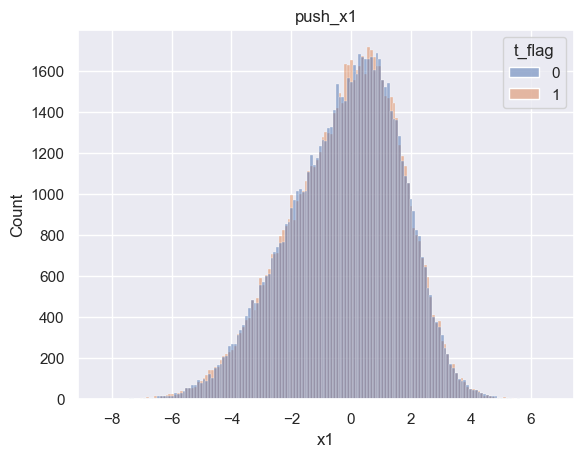

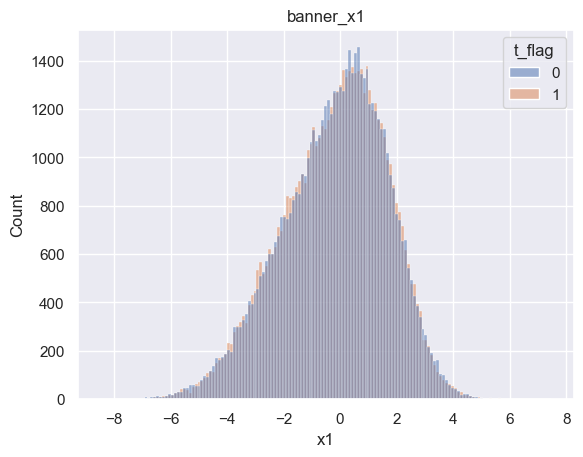

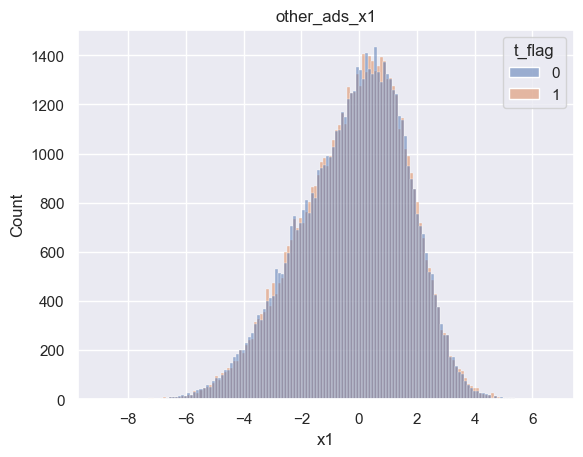

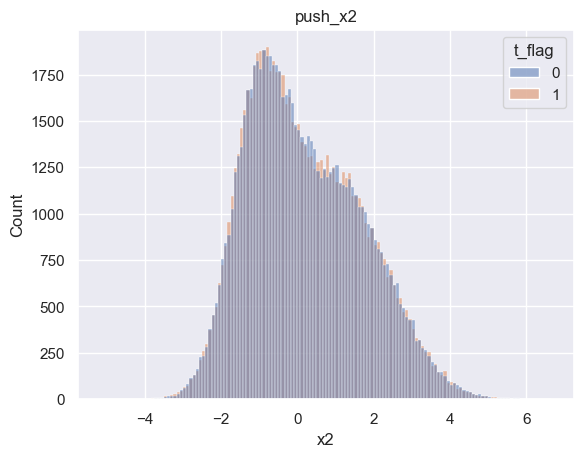

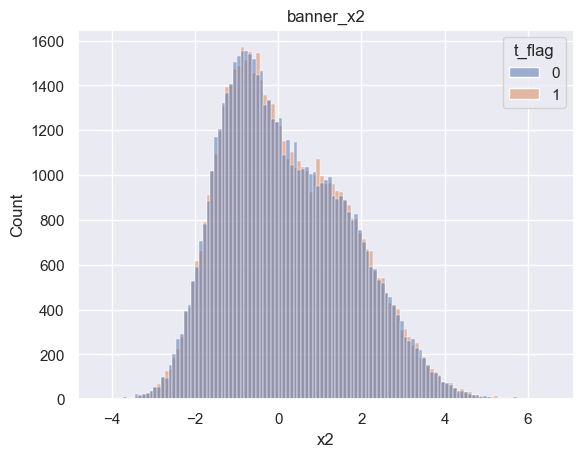

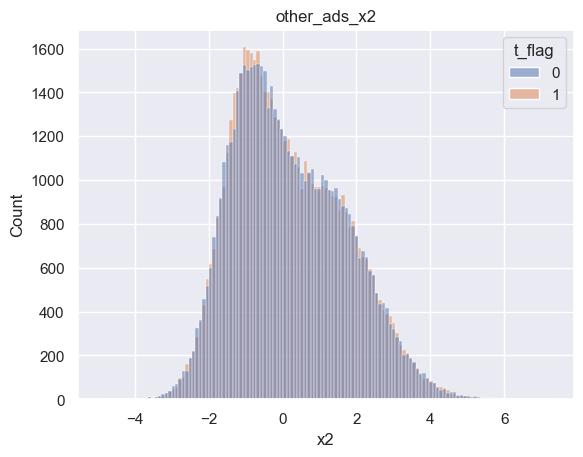

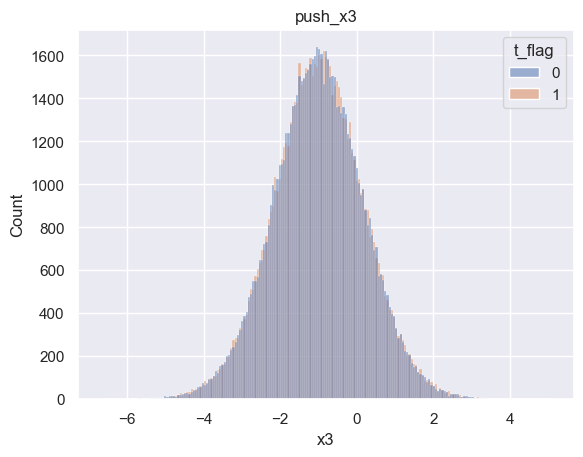

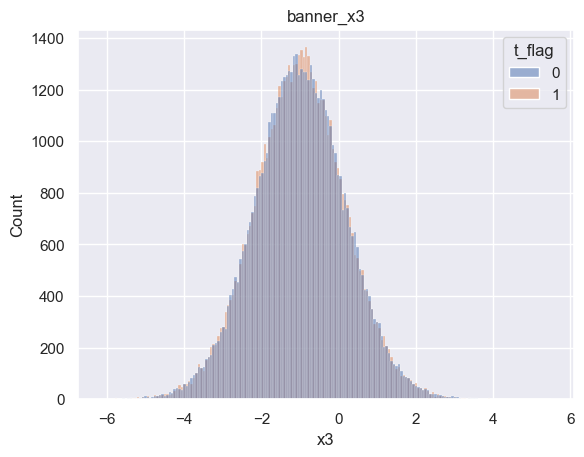

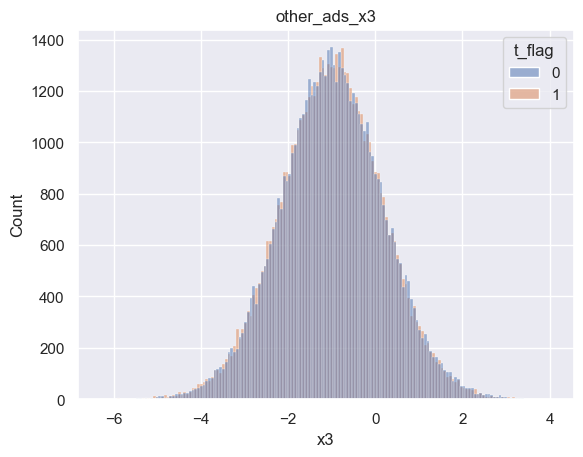

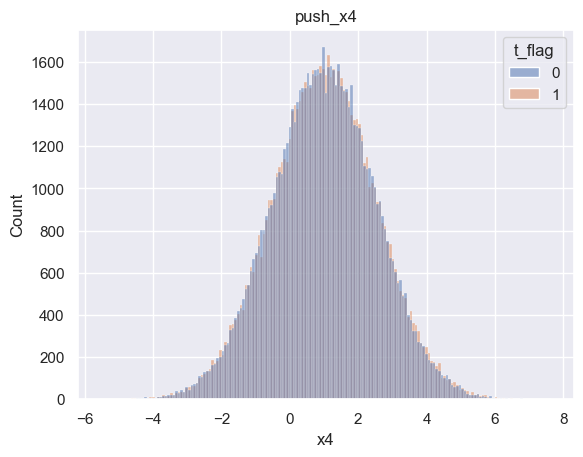

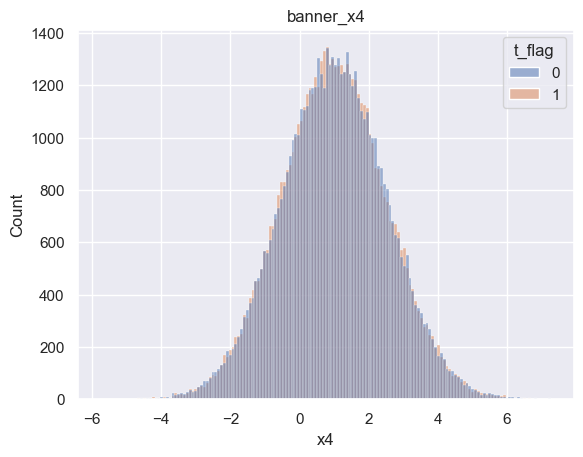

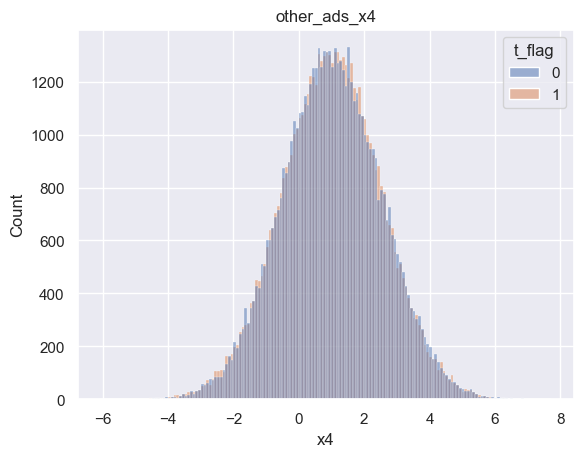

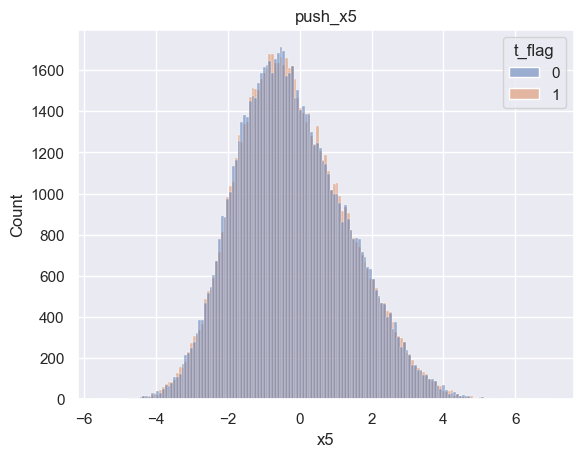

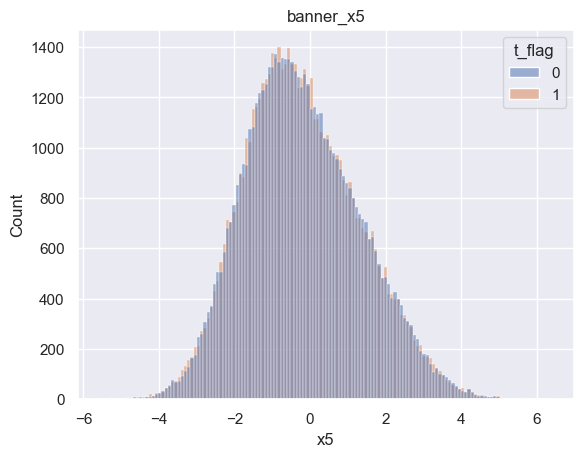

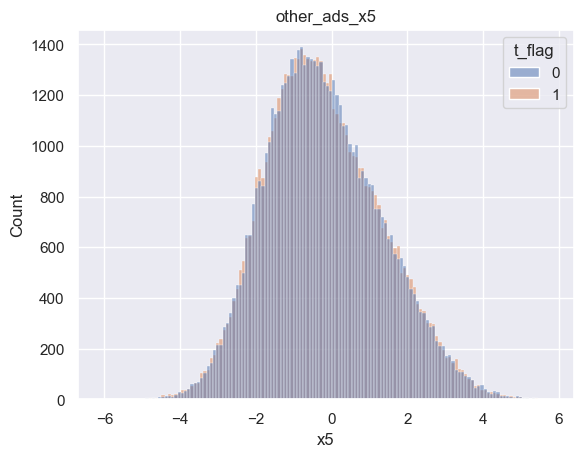

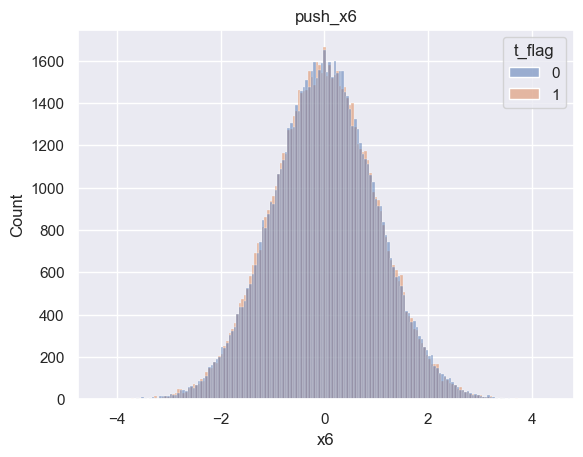

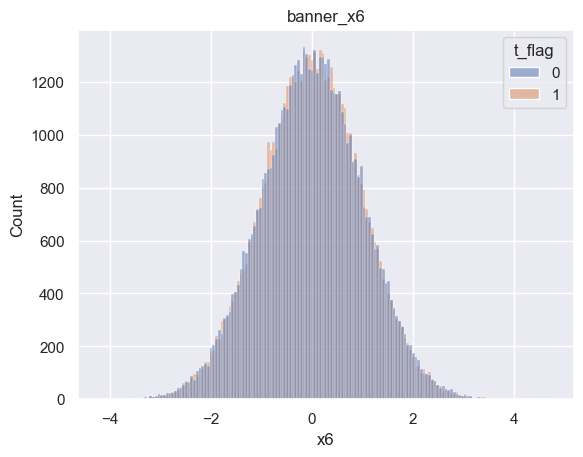

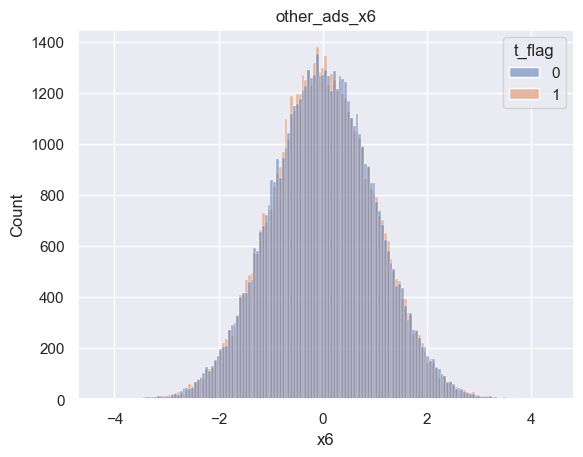

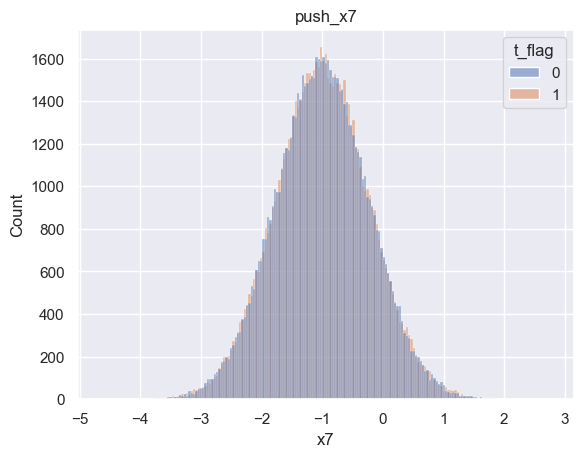

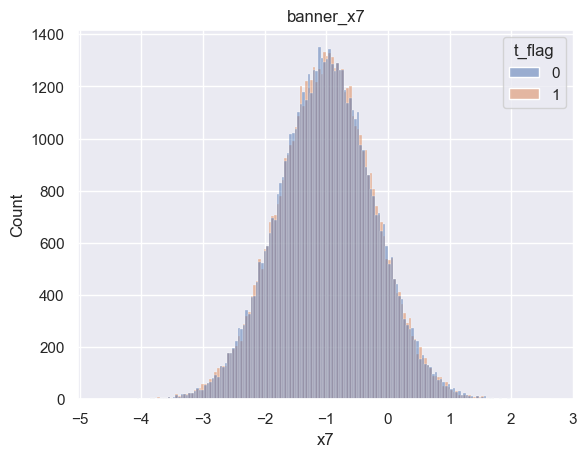

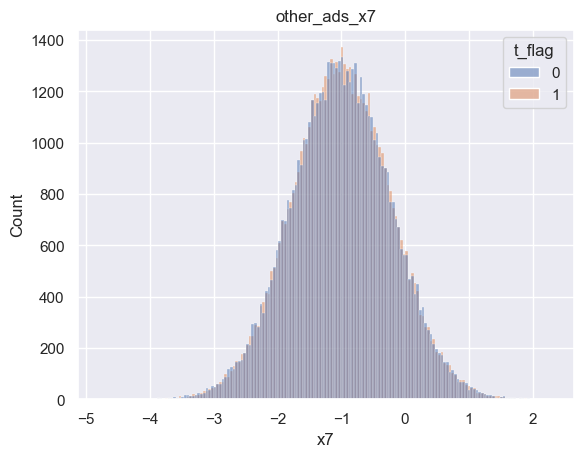

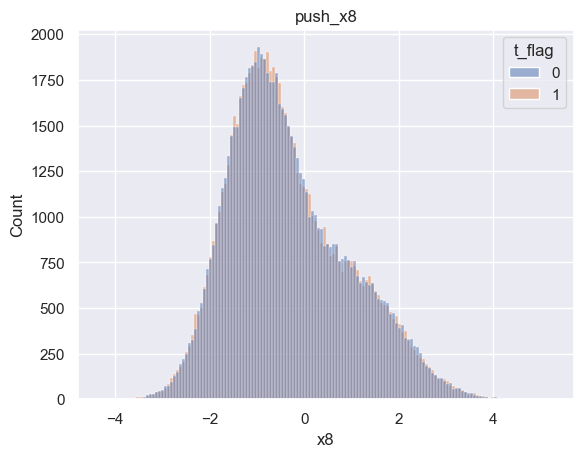

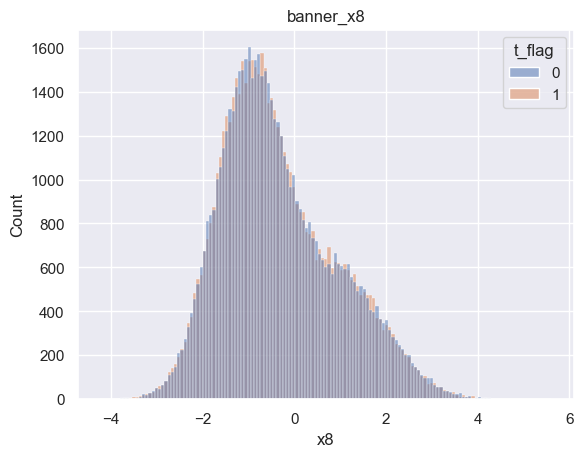

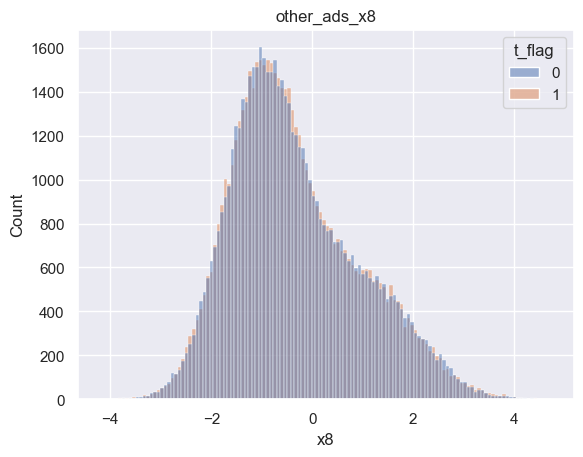

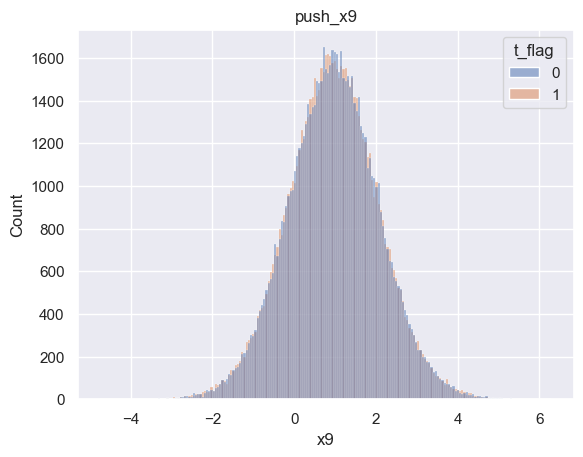

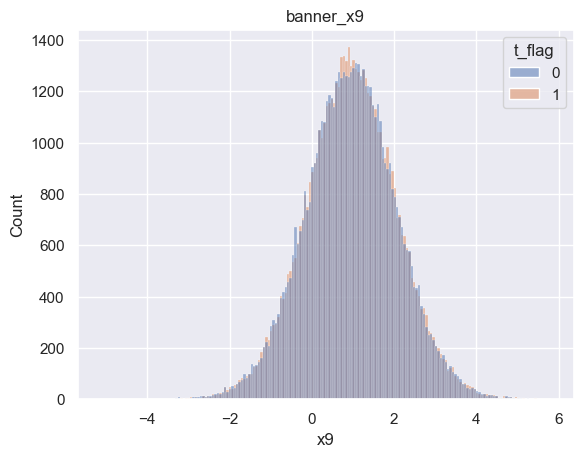

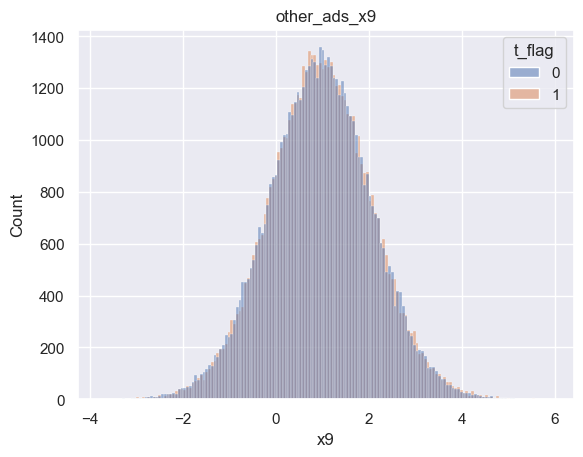

In [24]:
for col in ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9']:
    for channel in data['channel'].unique():
        sns.histplot(data = data[data['channel'] == channel], x=col, hue='t_flag').set_title(channel+'_'+col)
        plt.show()

`Таргет распределен довольно равномерно между контрольной и целевой группами.`

`Посмотрим, насколько различия между значениями признаков целевой и контрольной группы статистически значимы.`

In [25]:
for col in ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9']:
    for channel in data['channel'].unique():
        control = data[(data['channel'] == channel) & (data['t_flag'] == 0)][col]
        test = data[(data['channel'] == channel) & (data['t_flag'] == 1)][col]
        psi = calculate_psi(expected=control, actual=test)
        print(f'psi для признака {col} для канала {channel} равно {psi}')

psi для признака x1 для канала push равно 0.0001098913001516668
psi для признака x1 для канала banner равно 0.0006486708415836611
psi для признака x1 для канала other_ads равно 0.00030992430236189246
psi для признака x2 для канала push равно 0.00027925757354007485
psi для признака x2 для канала banner равно 0.0002745948556038454
psi для признака x2 для канала other_ads равно 0.0004962062612655458
psi для признака x3 для канала push равно 0.0003325565061805237
psi для признака x3 для канала banner равно 0.00027697031185206465
psi для признака x3 для канала other_ads равно 0.00024770786053765064
psi для признака x4 для канала push равно 0.0003944846026601528
psi для признака x4 для канала banner равно 0.0005434407037837626
psi для признака x4 для канала other_ads равно 0.0008290886058612407
psi для признака x5 для канала push равно 0.00017301163513621753
psi для признака x5 для канала banner равно 0.0002081431102083886
psi для признака x5 для канала other_ads равно 0.00025269410832455275

In [26]:
# посмотрим на схожесть форм распределений (будем использовать непараметрический тест Манна-Уитни)
for col in ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9']:
    for channel in data['channel'].unique():
        control = data[(data['channel'] == channel) & (data['t_flag'] == 0)][col]
        test = data[(data['channel'] == channel) & (data['t_flag'] == 1)][col]
        _, p_value = mannwhitneyu(control, test)
        print(f'p-values для признака {col} для канала {channel} равно {p_value}')

p-values для признака x1 для канала push равно 0.903940305438317
p-values для признака x1 для канала banner равно 0.3699044558344562
p-values для признака x1 для канала other_ads равно 0.20857522872844636
p-values для признака x2 для канала push равно 0.09675655023284845
p-values для признака x2 для канала banner равно 0.08505712714682147
p-values для признака x2 для канала other_ads равно 0.44614939000856324
p-values для признака x3 для канала push равно 0.23771434971427785
p-values для признака x3 для канала banner равно 0.4155549060667717
p-values для признака x3 для канала other_ads равно 0.05333486231119979
p-values для признака x4 для канала push равно 0.07858790238284935
p-values для признака x4 для канала banner равно 0.14001631706944864
p-values для признака x4 для канала other_ads равно 0.3450276994241789
p-values для признака x5 для канала push равно 0.18006359874209255
p-values для признака x5 для канала banner равно 0.3148626330807046
p-values для признака x5 для канала ot

`И PSI и тест Манна-Уитни показали, что все распределения совпадают. Значимых различий между контрольными и целевыми группами не обнаружено.`

In [27]:
# оставим только нужные там признаки (признаки клиентов, флаг группы, канал коммуникаций, таргет)
data = data[['t_flag',  'channel', 'target', 'x1', 'x2', 'x3',
       'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'age', 'city']]
data.head()

,t_flag,channel,target,x1,x2,x3,x4,x5,x6,x7,x8,x9,age,city
0,1,push,1,-1.440386,2.626965,-0.554468,1.256096,-0.126117,0.796936,-2.482924,0.286217,0.568191,39,Moscow
1,1,push,0,-2.876481,0.825156,0.096972,1.522668,-0.480667,0.516981,-2.809430,-0.870314,-0.036394,43,Moscow
2,0,push,0,-0.926523,1.672010,-2.129563,0.495003,-0.128326,-1.384427,-1.584175,0.710775,2.027874,39,Ufa
3,0,banner,0,3.119314,-2.612990,-0.938561,0.051391,0.181579,0.967456,-2.334746,0.994710,0.925518,30,Smolensk
4,1,other_ads,0,0.963743,-1.352470,-0.576820,2.198695,-0.018295,-1.004586,-0.271401,1.910492,0.546214,25,Moscow


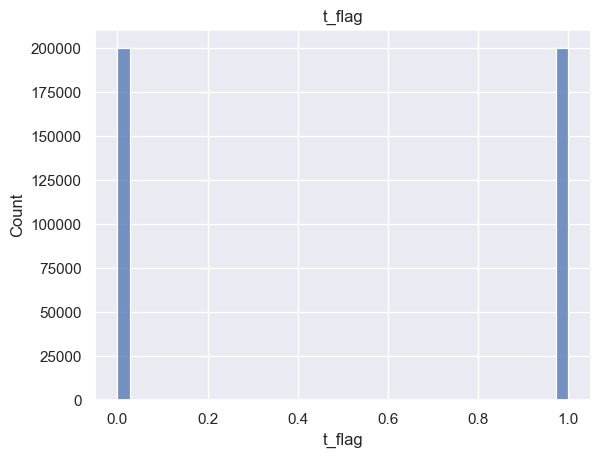

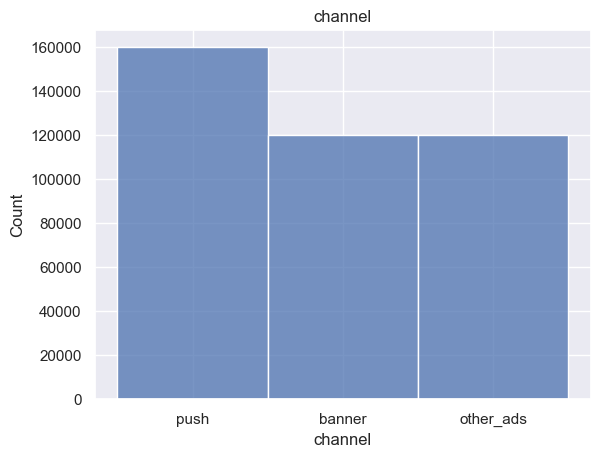

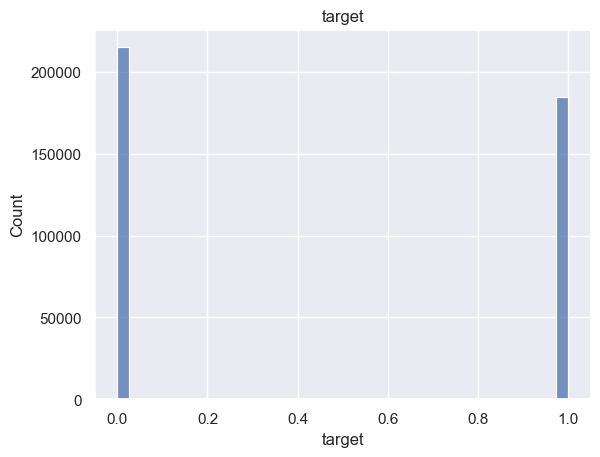

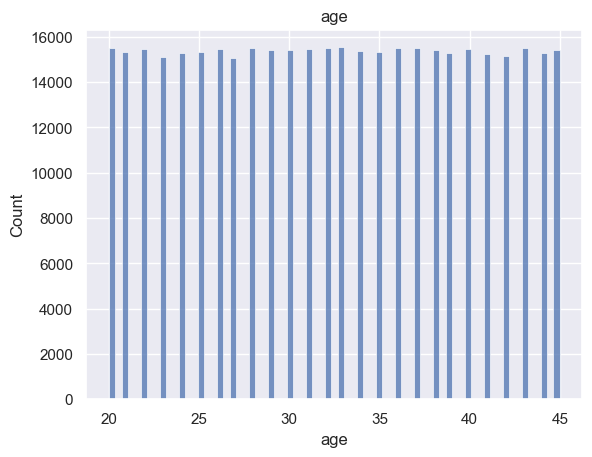

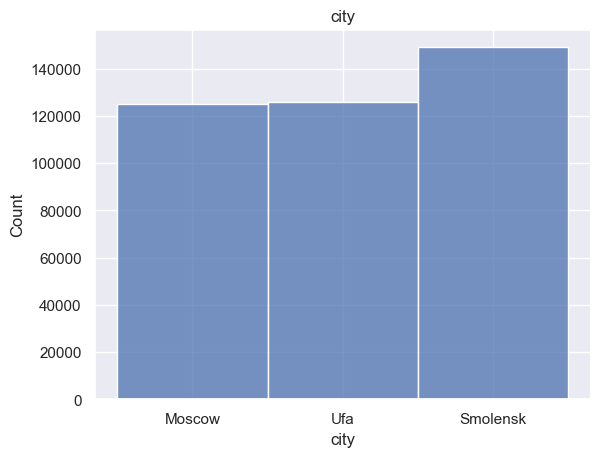

In [28]:
# посмотрим на распределения оставшихся признаков
for col in ['t_flag', 'channel', 'target', 'age', 'city']:
    sns.histplot(data[col])
    plt.title(col)
    plt.show()

`В датасете присутствует только 3 города: Смоленск, Уфа и Москва. Посмотрим на распределение конверсии по городам.`

In [29]:
conv = data.groupby(['city', 'channel', 't_flag']).agg(
    group_size=('target', 'size'),
    success=('target', 'sum')
)
conv['conversion'] = conv['success'] / conv['group_size']
conv

group_size  success  conversion
city     channel   t_flag                                 
Moscow   banner    0            19954     7964    0.399118
                   1            19858    11950    0.601773
         other_ads 0            12033     4868    0.404554
                   1            19819    11902    0.600535
         push      0            26705     5474    0.204980
                   1            26643    16069    0.603123
Smolensk banner    0            20036     8013    0.399930
                   1            20017    12178    0.608383
         other_ads 0            36056    14306    0.396772
                   1            20006    12031    0.601370
         push      0            26380     5298    0.200834
                   1            26585    15969    0.600677
Ufa      banner    0            20010     8067    0.403148
                   1            20125    12035    0.598012
         other_ads 0            11911     4870    0.408866
                   1            20175    12230    0.606196
         push      0            26915     5400    0.200632
                   1            26772    16101    0.601412

`Имеем "идеальные" данные :) В каждом городе конверсии по каналам идентичны.`

<h2> 3. Построение моделей и оценка их качества (14 баллов)</h2>

Постройте Uplift модели по собранным кампаниям, проведите тюнинг гиперпараметров и оцените их качество (qini score). Для каждой модели также постройте qini-curve.

**Комментарий по заданиям и оцениванию:**

1. Реализован только подход Solomodel без дополнительных библиотек и калибровок  - **1 балл**

2. Реализован Solomodel или Twomodel через Sklift или CausalML - **2 балла**

3. Учтена калибровка Metalearner'ах - **2 балла**

4. Корректно реализован ClassTransformation - **2 балла**

5. Реализован UpliftRandomForest - **4 балла**

6. Использованы пайплайны в Sklift - **2 балла**

7. Реализован тюнинг ( Gridsearch \ Optuna ) - **1 балл**

In [30]:
#  добавлю поле для стратификации
data['stratify'] = data['t_flag'].astype(str) + '_' + data['target'].astype(str)
data.head()

,t_flag,channel,target,x1,x2,x3,x4,x5,x6,x7,x8,x9,age,city,stratify
0,1,push,1,-1.440386,2.626965,-0.554468,1.256096,-0.126117,0.796936,-2.482924,0.286217,0.568191,39,Moscow,1_1
1,1,push,0,-2.876481,0.825156,0.096972,1.522668,-0.480667,0.516981,-2.809430,-0.870314,-0.036394,43,Moscow,1_0
2,0,push,0,-0.926523,1.672010,-2.129563,0.495003,-0.128326,-1.384427,-1.584175,0.710775,2.027874,39,Ufa,0_0
3,0,banner,0,3.119314,-2.612990,-0.938561,0.051391,0.181579,0.967456,-2.334746,0.994710,0.925518,30,Smolensk,0_0
4,1,other_ads,0,0.963743,-1.352470,-0.576820,2.198695,-0.018295,-1.004586,-0.271401,1.910492,0.546214,25,Moscow,1_0


In [31]:
# разделяю данные по кампаниям (для каждой кампании будем строить свою модель)
push_df = data[data['channel'] == 'push'].drop(columns=['channel']).reset_index(drop=True)
banner_df = data[data['channel'] == 'banner'].drop(columns=['channel']).reset_index(drop=True)
other_ads_df = data[data['channel'] == 'other_ads'].drop(columns=['channel']).reset_index(drop=True)

push_df.shape, banner_df.shape, other_ads_df.shape

((160000, 14), (120000, 14), (120000, 14))

In [32]:
# преобразую категориальные фичи (фичу) методом OneHotEncoding

push_df = pd.concat([push_df.drop(columns=['city']), pd.get_dummies(push_df[['city']], drop_first=True).astype(int)], axis=1)
banner_df = pd.concat([banner_df.drop(columns=['city']), pd.get_dummies(banner_df[['city']], drop_first=True).astype(int)], axis=1)
other_ads_df = pd.concat([other_ads_df.drop(columns=['city']), pd.get_dummies(other_ads_df[['city']], drop_first=True).astype(int)], axis=1)

In [33]:
X_train_push, X_test_push, y_train_push, y_test_push = train_test_split(push_df.drop(columns=['stratify', 'target']), push_df['target'], test_size=0.25, stratify=push_df['stratify'], random_state=RANDOM_STATE)
X_train_banner, X_test_banner, y_train_banner, y_test_banner = train_test_split(banner_df.drop(columns=['stratify', 'target']), banner_df['target'], test_size=0.25, stratify=banner_df['stratify'], random_state=RANDOM_STATE)
X_train_other, X_test_other, y_train_other, y_test_other = train_test_split(other_ads_df.drop(columns=['stratify','target']), other_ads_df['target'], test_size=0.25, stratify=other_ads_df['stratify'], random_state=RANDOM_STATE)

In [34]:
X_train_push.shape, X_train_banner.shape, X_train_other.shape

((120000, 13), (90000, 13), (90000, 13))

#### 1. Solomodel без доп библиотек

In [35]:
# в качестве базовой модели ML буду использовать LogReg
from sklearn.linear_model import LogisticRegression

In [36]:
lr_push = LogisticRegression(random_state=RANDOM_STATE)
lr_push.fit(X_train_push, y_train_push)

lr_banner = LogisticRegression(random_state=RANDOM_STATE)
lr_banner.fit(X_train_banner, y_train_banner)

lr_other = LogisticRegression(random_state=RANDOM_STATE)
lr_other.fit(X_train_other, y_train_other)

LogisticRegression(random_state=42)

In [37]:
# для каждой кампании рассчитаем uplift

# push
X_test_push_0 = X_test_push.copy()
X_test_push_0['t_flag'] = 0
y_pred_push_0 = lr_push.predict_proba(X_test_push_0)[:, 1]
X_test_push_1 = X_test_push.copy()
X_test_push_1['t_flag'] = 1
y_pred_push_1 = lr_push.predict_proba(X_test_push_1)[:, 1]
uplift_push = y_pred_push_1 - y_pred_push_0

# banner
X_test_banner_0 = X_test_banner.copy()
X_test_banner_0['t_flag'] = 0
y_pred_banner_0 = lr_banner.predict_proba(X_test_banner_0)[:, 1]
X_test_banner_1 = X_test_banner.copy()
X_test_banner_1['t_flag'] = 1
y_pred_banner_1 = lr_banner.predict_proba(X_test_banner_1)[:, 1]
uplift_banner = y_pred_banner_1 - y_pred_banner_0

# other_ads
X_test_other_0 = X_test_other.copy()
X_test_other_0['t_flag'] = 0
y_pred_other_0 = lr_other.predict_proba(X_test_other_0)[:, 1]
X_test_other_1 = X_test_other.copy()
X_test_other_1['t_flag'] = 1
y_pred_other_1 = lr_other.predict_proba(X_test_other_1)[:, 1]
uplift_other = y_pred_other_1 - y_pred_other_0


In [38]:
# рассчитаем qini score для каждой модели
qini_push = qini_auc_score(y_true=y_test_push, uplift=uplift_push, treatment=X_test_push['t_flag'])
qini_banner = qini_auc_score(y_true=y_test_banner, uplift=uplift_banner, treatment=X_test_banner['t_flag'])
qini_other = qini_auc_score(y_true=y_test_other, uplift=uplift_other, treatment=X_test_other['t_flag'])
avg_qini = np.mean([qini_push, qini_banner, qini_other])

print(f'{qini_push=}')
print(f'{qini_banner=}')
print(f'{qini_other=}')
print(f'{avg_qini=}')

qini_push=-0.005171880043981259
qini_banner=0.00023551129341991986
qini_other=-0.01106494802630993
avg_qini=-0.00533377225895709


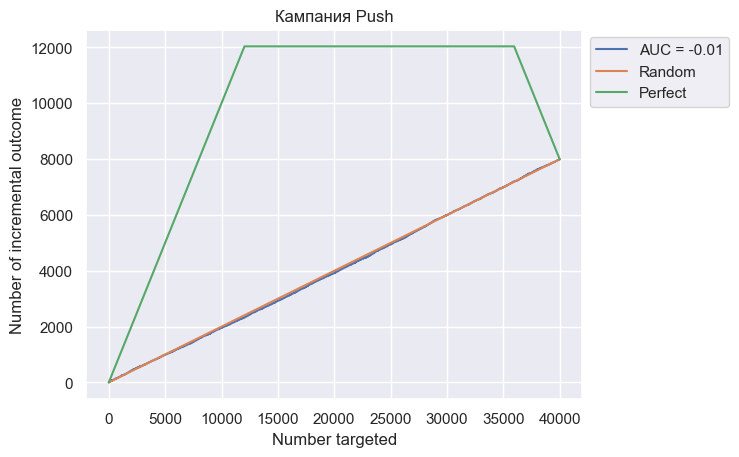

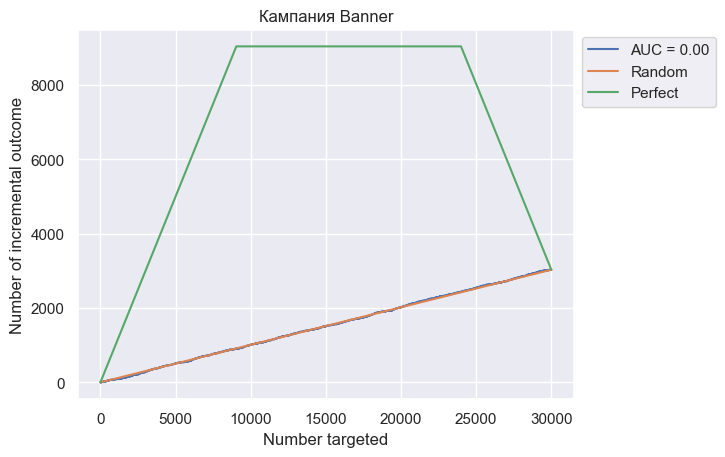

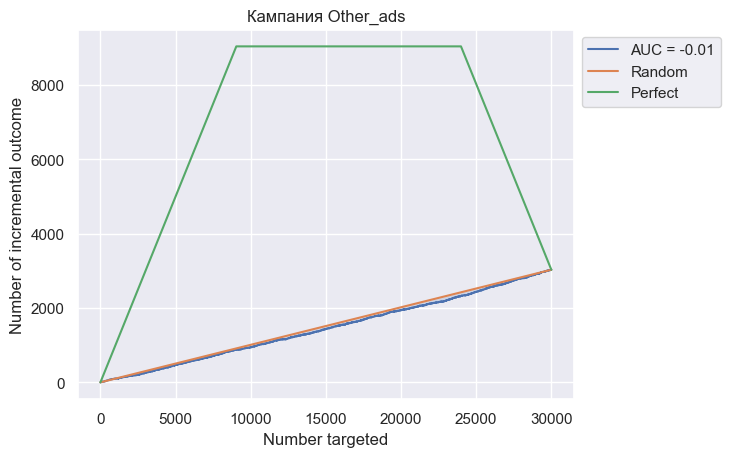

In [39]:
plot_qini_curve(y_true=y_test_push, uplift=uplift_push, treatment=X_test_push['t_flag'])
plt.title('Кампания Push')
plt.show()

plot_qini_curve(y_true=y_test_banner, uplift=uplift_banner, treatment=X_test_banner['t_flag'])
plt.title('Кампания Banner')
plt.show()

plot_qini_curve(y_true=y_test_other, uplift=uplift_other, treatment=X_test_other['t_flag'])
plt.title('Кампания Other_ads')
plt.show()

`Результат оказался чуть хуже рандома :/`

#### 2. TwoModels через sklift

In [40]:
from sklift.models import TwoModels

# чтобы не писать идентичный код 3 раза напишу-ка я функцию
def get_two_models_qini_score(estimator1, estimator2, X_train, y_train, X_test, y_test):
    model = TwoModels(estimator1, estimator2)
    model.fit(X_train.drop(columns=['t_flag']), y_train, X_train['t_flag'])
    tm_uplift = model.predict(X_test.drop(columns=['t_flag']))
    qini_score = qini_auc_score(y_true=y_test, uplift=tm_uplift, treatment=X_test['t_flag'])
    return qini_score, tm_uplift


qini_push, uplift_push = get_two_models_qini_score(LogisticRegression(random_state=RANDOM_STATE+1), LogisticRegression(random_state=RANDOM_STATE+2), X_train_push, y_train_push, X_test_push, y_test_push)
qini_banner, uplift_banner = get_two_models_qini_score(LogisticRegression(random_state=RANDOM_STATE+1), LogisticRegression(random_state=RANDOM_STATE+2), X_train_banner, y_train_banner, X_test_banner, y_test_banner)
qini_other, uplift_other = get_two_models_qini_score(LogisticRegression(random_state=RANDOM_STATE+1), LogisticRegression(random_state=RANDOM_STATE+2), X_train_other, y_train_other, X_test_other, y_test_other)
avg_qini = np.mean([qini_push, qini_banner, qini_other])

print(f'{qini_push=}')
print(f'{qini_banner=}')
print(f'{qini_other=}')
print(f'{avg_qini=}')

qini_push=0.0026977258855202203
qini_banner=-0.004288821713607249
qini_other=-0.022668687084616095
avg_qini=-0.008086594304234375


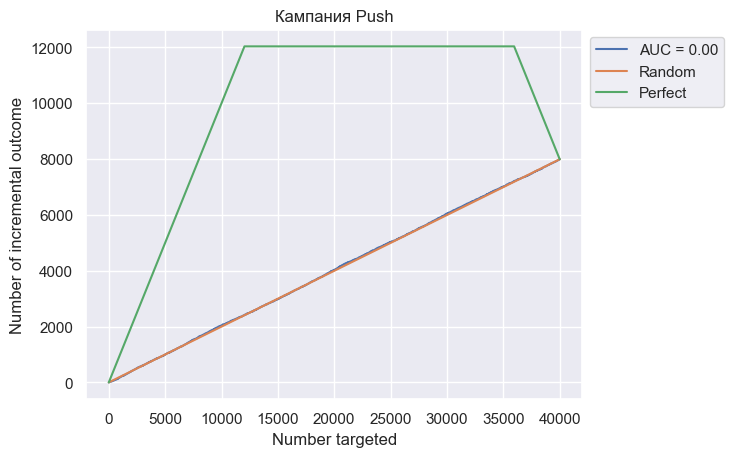

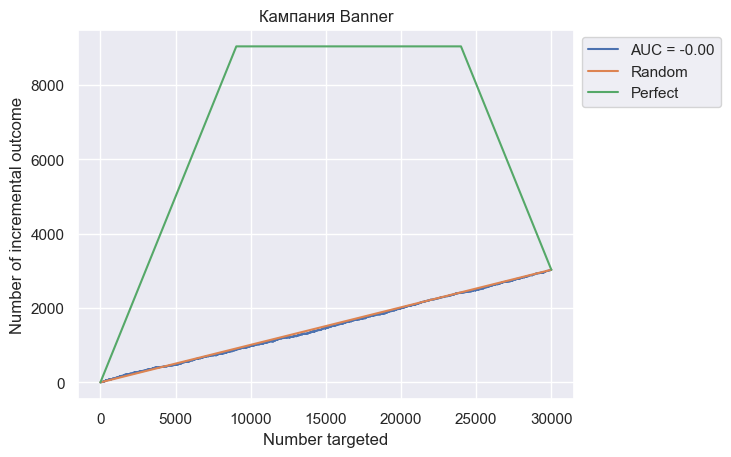

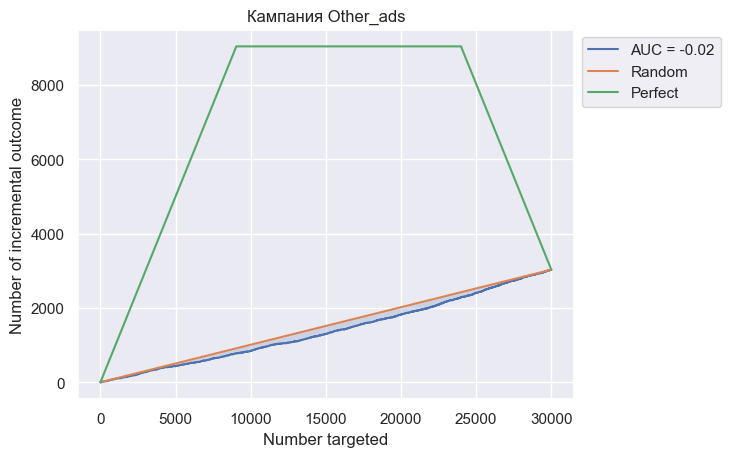

In [41]:
plot_qini_curve(y_true=y_test_push, uplift=uplift_push, treatment=X_test_push['t_flag'])
plt.title('Кампания Push')
plt.show()

plot_qini_curve(y_true=y_test_banner, uplift=uplift_banner, treatment=X_test_banner['t_flag'])
plt.title('Кампания Banner')
plt.show()

plot_qini_curve(y_true=y_test_other, uplift=uplift_other, treatment=X_test_other['t_flag'])
plt.title('Кампания Other_ads')
plt.show()


`Результат даже чуть хуже, чем у SoloModel... Но теперь пуши имеют положительный qini score.`

#### 3. Учтена калибровка Metalearner'ах

Здесь и далее в качестве базовой модели буду брать CatBoostClassifier

In [40]:
def get_calib_solo_model_qini_score(X_train, y_train, X_test, y_test):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    base_model = CatBoostClassifier(logging_level='Silent', random_state=RANDOM_STATE, thread_count=-1)
    calib_base_model = CalibratedClassifierCV(base_model, method='isotonic', cv=skf)
    solo = SoloModel(calib_base_model)
    solo.fit(X_train.drop(columns=['t_flag']), y_train, treatment=X_train['t_flag'])
    uplift = solo.predict(X_test.drop(columns=['t_flag']))
    qini_score = qini_auc_score(y_true=y_test, uplift=uplift, treatment=X_test['t_flag'])
    return qini_score, uplift

qini_push, uplift_push = get_calib_solo_model_qini_score(X_train_push, y_train_push, X_test_push, y_test_push)
qini_banner, uplift_banner = get_calib_solo_model_qini_score(X_train_banner, y_train_banner, X_test_banner, y_test_banner)
qini_other, uplift_other = get_calib_solo_model_qini_score(X_train_other, y_train_other, X_test_other, y_test_other)
avg_qini = np.mean([qini_push, qini_banner, qini_other])

print(f'{qini_push=}')
print(f'{qini_banner=}')
print(f'{qini_other=}')
print(f'{avg_qini=}')

qini_push=0.004239336261657495
qini_banner=-0.0007513423839206559
qini_other=-0.003060984534509487
avg_qini=0.0001423364477424506


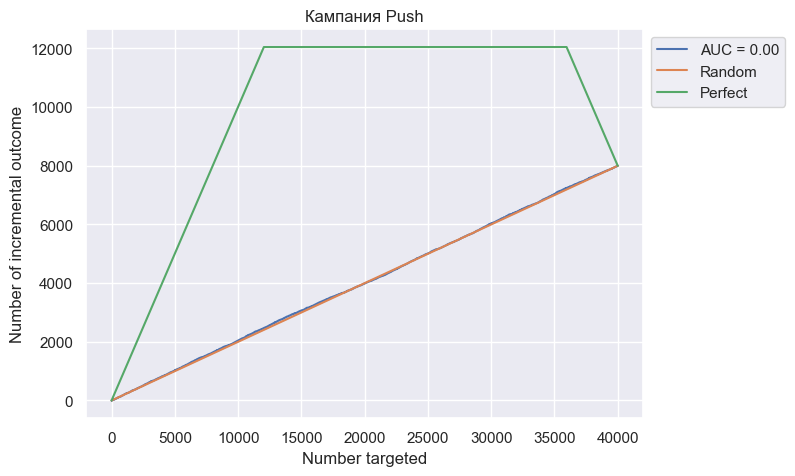

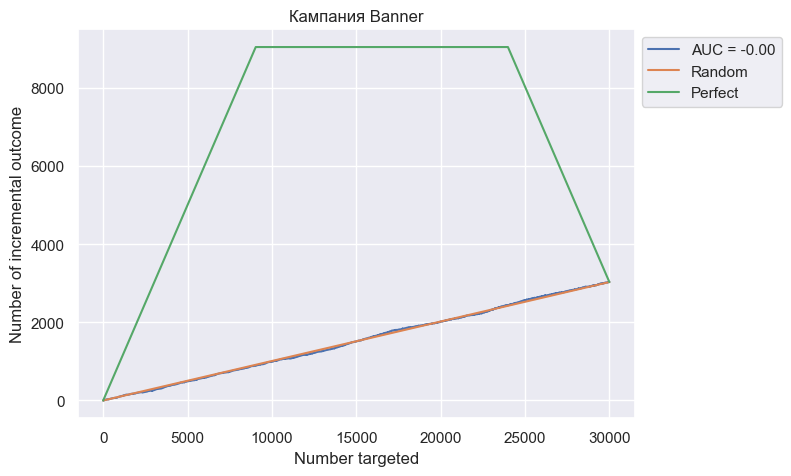

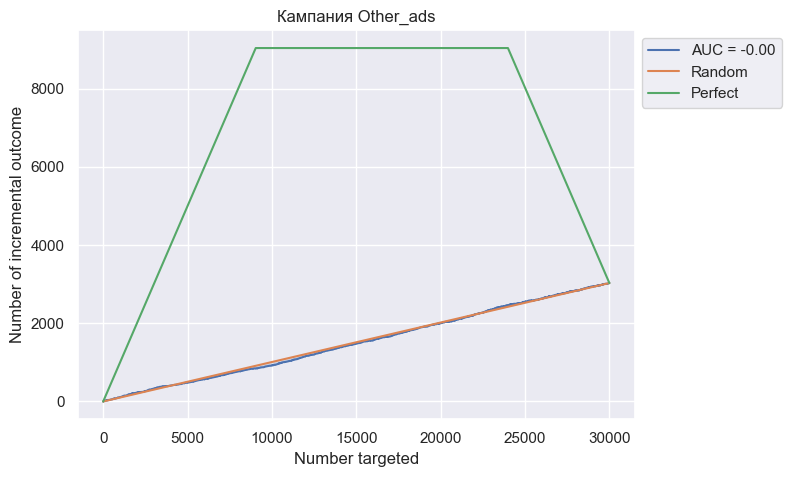

In [41]:
plot_qini_curve(y_true=y_test_push, uplift=uplift_push, treatment=X_test_push['t_flag'])
plt.title('Кампания Push')
plt.show()

plot_qini_curve(y_true=y_test_banner, uplift=uplift_banner, treatment=X_test_banner['t_flag'])
plt.title('Кампания Banner')
plt.show()

plot_qini_curve(y_true=y_test_other, uplift=uplift_other, treatment=X_test_other['t_flag'])
plt.title('Кампания Other_ads')
plt.show()

`Qini score уже положительный, но по сути равен значению рандома.`

#### 4. реализован ClassTransformation

In [42]:
def get_class_transform_qini_score(X_train, y_train, X_test, y_test):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    base_model = CatBoostClassifier(logging_level='Silent', random_state=RANDOM_STATE, thread_count=-1)
    calib_base_model = CalibratedClassifierCV(base_model, method='isotonic', cv=skf)
    
    class_transf = ClassTransformation(calib_base_model)
    class_transf.fit(X_train.drop(columns=['t_flag']), y_train, treatment=X_train['t_flag'])
    uplift = class_transf.predict(X_test.drop(columns=['t_flag']))
    qini_score = qini_auc_score(y_true=y_test, uplift=uplift, treatment=X_test['t_flag'])
    return qini_score, uplift

In [43]:
qini_push, uplift_push = get_class_transform_qini_score(X_train_push, y_train_push, X_test_push, y_test_push)
qini_banner, uplift_banner = get_class_transform_qini_score(X_train_banner, y_train_banner, X_test_banner, y_test_banner)
qini_other, uplift_other = get_class_transform_qini_score(X_train_other, y_train_other, X_test_other, y_test_other)
avg_qini = np.mean([qini_push, qini_banner, qini_other])

print(f'{qini_push=}')
print(f'{qini_banner=}')
print(f'{qini_other=}')
print(f'{avg_qini=}')

qini_push=-0.0064825289380226435
qini_banner=0.0058131187484722424
qini_other=0.0006493136624899541
avg_qini=-6.698842353482328e-06


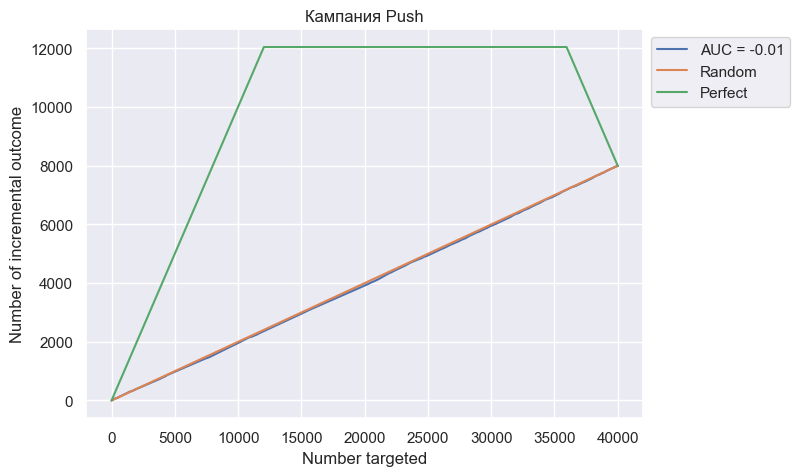

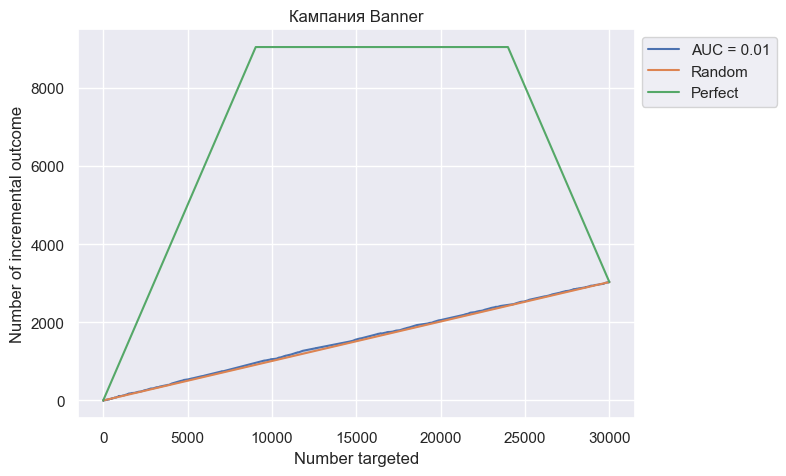

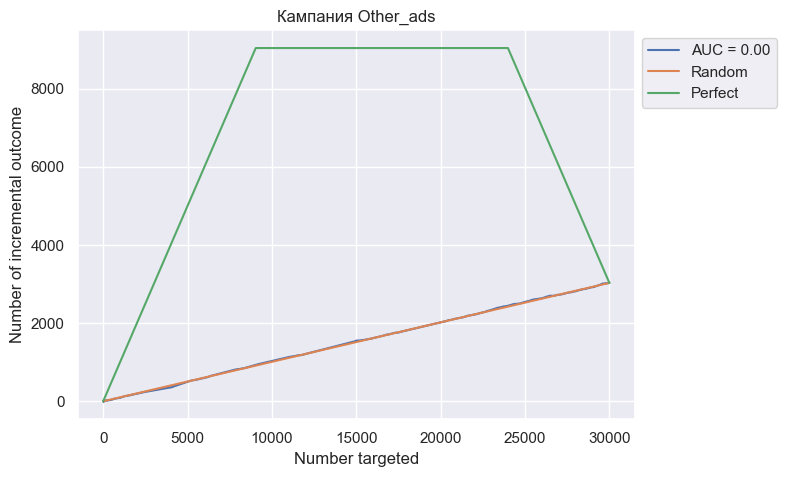

In [44]:
plot_qini_curve(y_true=y_test_push, uplift=uplift_push, treatment=X_test_push['t_flag'])
plt.title('Кампания Push')
plt.show()

plot_qini_curve(y_true=y_test_banner, uplift=uplift_banner, treatment=X_test_banner['t_flag'])
plt.title('Кампания Banner')
plt.show()

plot_qini_curve(y_true=y_test_other, uplift=uplift_other, treatment=X_test_other['t_flag'])
plt.title('Кампания Other_ads')
plt.show()

`Результат хуже, чем просто у калиброванного бустинга...`

#### 5. Реализован UpliftRandomForest

In [45]:
def get_random_forest_qini_score(X_train, y_train, X_test, y_test):
    X_train['t_flag'] = X_train['t_flag'].astype(str)
    X_test['t_flag'] = X_test['t_flag'].astype(str)

    uplift_rf = UpliftRandomForestClassifier(control_name='0', random_state=RANDOM_STATE)
    uplift_rf.fit(X=X_train.drop(columns=['t_flag']).values, y=y_train.values, treatment=X_train['t_flag'].values)
    uplift_rf_pred = uplift_rf.predict(X=X_test.drop(columns=['t_flag']).values)    

    qini_score = qini_auc_score(y_true=y_test, uplift=uplift_rf_pred, treatment=X_test['t_flag'].astype(int))
    return qini_score, uplift_rf_pred

In [46]:
qini_push, uplift_push = get_random_forest_qini_score(X_train_push, y_train_push, X_test_push, y_test_push)
qini_banner, uplift_banner = get_random_forest_qini_score(X_train_banner, y_train_banner, X_test_banner, y_test_banner)
qini_other, uplift_other = get_random_forest_qini_score(X_train_other, y_train_other, X_test_other, y_test_other)
avg_qini = np.mean([qini_push, qini_banner, qini_other])

print(f'{qini_push=}')
print(f'{qini_banner=}')
print(f'{qini_other=}')
print(f'{avg_qini=}')

qini_push=-0.6633288218203212
qini_banner=-0.27240999395489557
qini_other=-0.27240999395489557
avg_qini=-0.40271626991003745


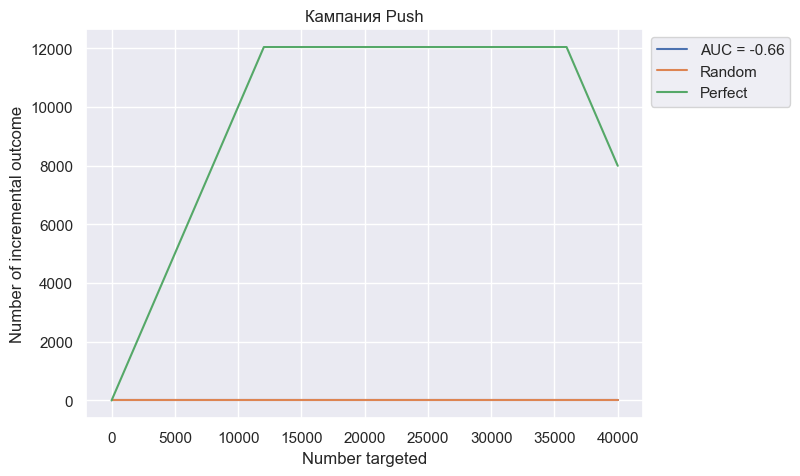

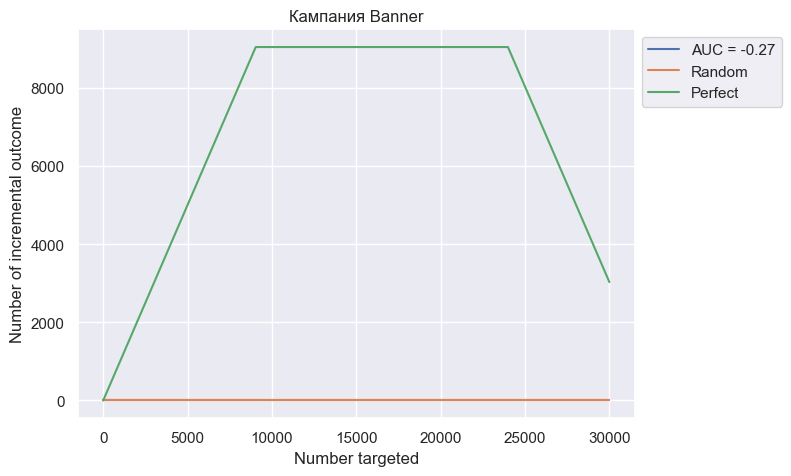

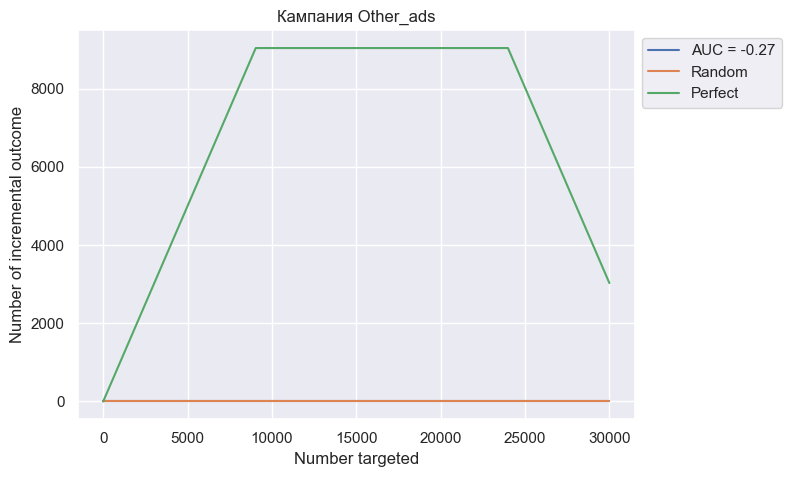

In [47]:
plot_qini_curve(y_true=y_test_push, uplift=uplift_push, treatment=X_test_push['t_flag'].astype(int))
plt.title('Кампания Push')
plt.show()

plot_qini_curve(y_true=y_test_banner, uplift=uplift_banner, treatment=X_test_banner['t_flag'].astype(int))
plt.title('Кампания Banner')
plt.show()

plot_qini_curve(y_true=y_test_other, uplift=uplift_other, treatment=X_test_other['t_flag'].astype(int))
plt.title('Кампания Other_ads')
plt.show()

`Результат qini=-0.4 даже хуже результата SoloModel.`

#### 6. Использованы пайплайны

In [43]:
def get_pipeline_qini_score(X_train, y_train, X_test, y_test):
    X_train['t_flag'] = X_train['t_flag'].astype(int)
    X_test['t_flag'] = X_test['t_flag'].astype(int)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    base_model = CatBoostClassifier(logging_level='Silent', random_state=RANDOM_STATE, thread_count=-1)
    calib_base_model = CalibratedClassifierCV(base_model, method='isotonic', cv=skf)
    solo = SoloModel(calib_base_model)
    pipe = Pipeline(steps=[
        ('scaler', MinMaxScaler()),
        ('model_uplift', solo)
    ])
    pipe.fit(X_train.drop(columns=['t_flag']).values,
            y_train.values,
            model_uplift__treatment=X_train['t_flag'].values)
    uplift_pipe_pred = pipe.predict(X=X_test.drop(columns=['t_flag']).values)
    qini_score = qini_auc_score(y_true=y_test, uplift=uplift_pipe_pred, treatment=X_test['t_flag'])
    return qini_score, uplift_pipe_pred

In [49]:
qini_push, uplift_push = get_pipeline_qini_score(X_train_push, y_train_push, X_test_push, y_test_push)
qini_banner, uplift_banner = get_pipeline_qini_score(X_train_banner, y_train_banner, X_test_banner, y_test_banner)
qini_other, uplift_other = get_pipeline_qini_score(X_train_other, y_train_other, X_test_other, y_test_other)
avg_qini = np.mean([qini_push, qini_banner, qini_other])

print(f'{qini_push=}')
print(f'{qini_banner=}')
print(f'{qini_other=}')
print(f'{avg_qini=}')

qini_push=0.0049740426809893904
qini_banner=0.001061937940672856
qini_other=0.0022569335384985314
avg_qini=0.002764304720053593


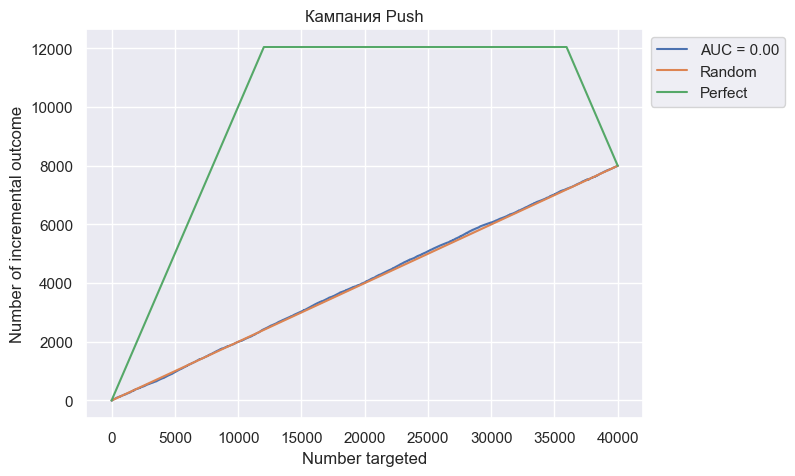

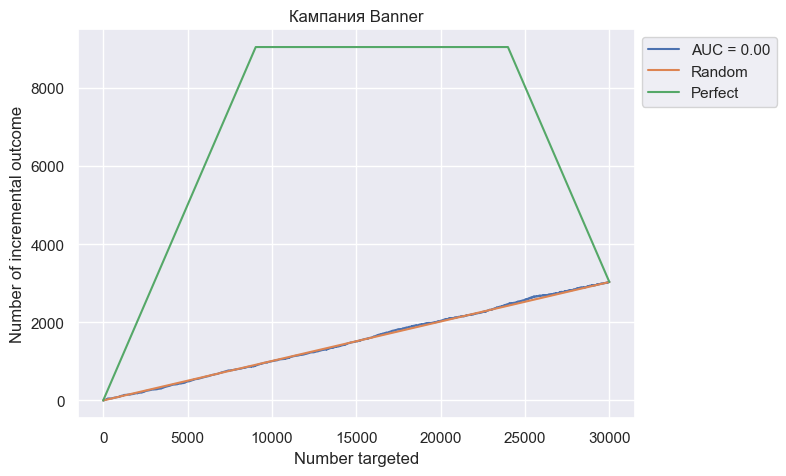

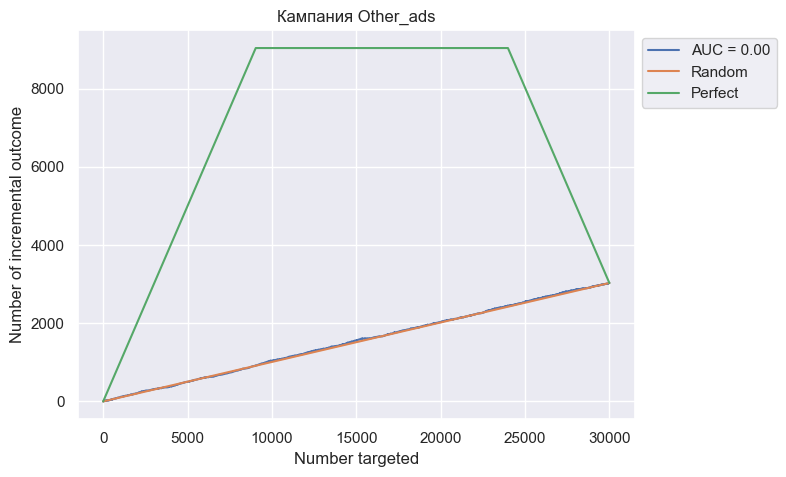

In [50]:
plot_qini_curve(y_true=y_test_push, uplift=uplift_push, treatment=X_test_push['t_flag'].astype(int))
plt.title('Кампания Push')
plt.show()

plot_qini_curve(y_true=y_test_banner, uplift=uplift_banner, treatment=X_test_banner['t_flag'].astype(int))
plt.title('Кампания Banner')
plt.show()

plot_qini_curve(y_true=y_test_other, uplift=uplift_other, treatment=X_test_other['t_flag'].astype(int))
plt.title('Кампания Other_ads')
plt.show()

`Получили наилучший результат среди всех рассмотренных моделей: qini score = 0.002 (в частности для пушей = 0.005)`

`Попробуем затюнить эту модель, чтобы достичь лучшего качества.`

#### 7. Реализован тюнинг ( Gridsearch \ Optuna )

In [191]:
import optuna

def objective_catboost_push(trial):
    learning_rate = trial.suggest_float("learning_rate", 1e-3, 1, log=True)
    n_estimators = trial.suggest_int("n_estimators", 50, 1000)
    max_depth = trial.suggest_int("max_depth", 1, 16)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    base_model = CatBoostClassifier(learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth, logging_level='Silent', random_state=RANDOM_STATE, thread_count=-1)
    calib_base_model = CalibratedClassifierCV(base_model, method='isotonic', cv=skf)
    solo_model = SoloModel(calib_base_model)

    pipe = Pipeline(steps=[
        ('scaler', MinMaxScaler()),
        ('model_uplift', solo_model)
    ])
    
    qini_scorer = make_uplift_scorer("qini_auc_score", X_train_push['t_flag'])
    cross_val = cross_validate(pipe,
                               X=X_train_push.drop(columns='t_flag'),
                               y=y_train_push,
                               params={'model_uplift__treatment':X_train_push['t_flag']},
                               scoring=qini_scorer,
                               cv=skf,
                               n_jobs=-1,
                               return_train_score=True)

    #мы ищем не просто самую лучшую модель, а самую стабильную
    return cross_val['test_score'].mean() - cross_val['test_score'].std()

def objective_catboost_banner(trial):
    learning_rate = trial.suggest_float("learning_rate", 1e-3, 1, log=True)
    n_estimators = trial.suggest_int("n_estimators", 50, 1000)
    max_depth = trial.suggest_int("max_depth", 1, 16)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    base_model = CatBoostClassifier(learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth, logging_level='Silent', random_state=RANDOM_STATE, thread_count=-1)
    calib_base_model = CalibratedClassifierCV(base_model, method='isotonic', cv=skf)
    solo_model = SoloModel(calib_base_model)

    pipe = Pipeline(steps=[
        ('scaler', MinMaxScaler()),
        ('model_uplift', solo_model)
    ])
    
    qini_scorer = make_uplift_scorer("qini_auc_score", X_train_banner['t_flag'])
    cross_val = cross_validate(pipe,
                               X=X_train_banner.drop(columns='t_flag'),
                               y=y_train_banner,
                               params={'model_uplift__treatment':X_train_banner['t_flag']},
                               scoring=qini_scorer,
                               cv=skf,
                               n_jobs=-1,
                               return_train_score=True)

    #мы ищем не просто самую лучшую модель, а самую стабильную
    return cross_val['test_score'].mean() - cross_val['test_score'].std()

def objective_catboost_other(trial):
    learning_rate = trial.suggest_float("learning_rate", 1e-3, 1, log=True)
    n_estimators = trial.suggest_int("n_estimators", 50, 1000)
    max_depth = trial.suggest_int("max_depth", 1, 16)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    base_model = CatBoostClassifier(learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth, logging_level='Silent', random_state=RANDOM_STATE, thread_count=-1)
    calib_base_model = CalibratedClassifierCV(base_model, method='isotonic', cv=skf)
    solo_model = SoloModel(calib_base_model)

    pipe = Pipeline(steps=[
        ('scaler', MinMaxScaler()),
        ('model_uplift', solo_model)
    ])
    
    qini_scorer = make_uplift_scorer("qini_auc_score", X_train_other['t_flag'])
    cross_val = cross_validate(pipe,
                               X=X_train_other.drop(columns='t_flag'),
                               y=y_train_other,
                               params={'model_uplift__treatment':X_train_other['t_flag']},
                               scoring=qini_scorer,
                               cv=skf,
                               n_jobs=-1,
                               return_train_score=True)

    #мы ищем не просто самую лучшую модель, а самую стабильную
    return cross_val['test_score'].mean() - cross_val['test_score'].std()



In [55]:
study_push = optuna.create_study(direction="maximize")
study_push.optimize(objective_catboost_push, n_trials=10)
study_push.best_params, study_push.best_value

[I 2025-02-27 19:23:06,282] A new study created in memory with name: no-name-ba2802c4-bc44-48bc-b9fd-192016a8ca02
[I 2025-02-27 19:24:12,736] Trial 0 finished with value: -0.00354254506520385 and parameters: {'learning_rate': 0.06556685775630693, 'n_estimators': 599, 'max_depth': 9}. Best is trial 0 with value: -0.00354254506520385.
[I 2025-02-27 19:36:28,577] Trial 1 finished with value: -0.007555709140585183 and parameters: {'learning_rate': 0.7246967611617414, 'n_estimators': 231, 'max_depth': 15}. Best is trial 0 with value: -0.00354254506520385.
[I 2025-02-27 19:36:47,936] Trial 2 finished with value: -0.008028723030247618 and parameters: {'learning_rate': 0.013741413592647824, 'n_estimators': 440, 'max_depth': 2}. Best is trial 0 with value: -0.00354254506520385.
[I 2025-02-27 19:46:37,795] Trial 3 finished with value: -0.009498297154252718 and parameters: {'learning_rate': 0.08317259794999514, 'n_estimators': 891, 'max_depth': 13}. Best is trial 0 with value: -0.0035425450652038

({'learning_rate': 0.06556685775630693, 'n_estimators': 599, 'max_depth': 9},
 -0.00354254506520385)

In [56]:
study_banner = optuna.create_study(direction="maximize")
study_banner.optimize(objective_catboost_banner, n_trials=10)
study_banner.best_params, study_banner.best_value

[I 2025-02-27 19:52:24,958] A new study created in memory with name: no-name-6b9f4017-d784-4804-86a5-e590074a328e
[I 2025-02-27 19:52:56,380] Trial 0 finished with value: -0.004282728119098052 and parameters: {'learning_rate': 0.03765862885989638, 'n_estimators': 888, 'max_depth': 3}. Best is trial 0 with value: -0.004282728119098052.
[I 2025-02-27 19:53:39,596] Trial 1 finished with value: -0.007903522042935882 and parameters: {'learning_rate': 0.004194939884900077, 'n_estimators': 911, 'max_depth': 6}. Best is trial 0 with value: -0.004282728119098052.
[I 2025-02-27 19:54:14,652] Trial 2 finished with value: -0.007565699796918553 and parameters: {'learning_rate': 0.017986785596811748, 'n_estimators': 379, 'max_depth': 9}. Best is trial 0 with value: -0.004282728119098052.
[I 2025-02-27 19:54:54,153] Trial 3 finished with value: -0.003968823205437447 and parameters: {'learning_rate': 0.7774392154691293, 'n_estimators': 415, 'max_depth': 9}. Best is trial 3 with value: -0.0039688232054

({'learning_rate': 0.5096307065917453, 'n_estimators': 495, 'max_depth': 3},
 -0.0017898758898016827)

In [193]:
study_other = optuna.create_study(direction="maximize")
study_other.optimize(objective_catboost_other, n_trials=10)
study_other.best_params, study_other.best_value

[I 2025-02-28 12:51:54,374] A new study created in memory with name: no-name-3f54ed6c-4253-4933-97ca-3d2b886897cc
[I 2025-02-28 12:52:29,693] Trial 0 finished with value: -0.006528522525308386 and parameters: {'learning_rate': 0.027684794443986114, 'n_estimators': 757, 'max_depth': 4}. Best is trial 0 with value: -0.006528522525308386.
[I 2025-02-28 12:55:30,452] Trial 1 finished with value: -0.007877822630857453 and parameters: {'learning_rate': 0.16561659342279358, 'n_estimators': 844, 'max_depth': 11}. Best is trial 0 with value: -0.006528522525308386.
[I 2025-02-28 12:55:46,701] Trial 2 finished with value: -0.004976800754194351 and parameters: {'learning_rate': 0.12051772029161745, 'n_estimators': 306, 'max_depth': 6}. Best is trial 2 with value: -0.004976800754194351.
[I 2025-02-28 12:58:05,504] Trial 3 finished with value: -0.006177203088191619 and parameters: {'learning_rate': 0.007385630945992105, 'n_estimators': 649, 'max_depth': 11}. Best is trial 2 with value: -0.0049768007

({'learning_rate': 0.48182269663747895, 'n_estimators': 708, 'max_depth': 9},
 -0.0030282925920961587)

In [200]:
# проверяем качество на тесте

def get_tuned_pipeline_qini_score(learning_rate, n_estimators, max_depth, X_train, y_train, X_test, y_test):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    base_model = CatBoostClassifier(learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth, logging_level='Silent', random_state=RANDOM_STATE, thread_count=-1)
    calib_base_model = CalibratedClassifierCV(base_model, method='isotonic', cv=skf)
    solo_model = SoloModel(calib_base_model)

    pipe_push = Pipeline(steps=[
        ('scaler', MinMaxScaler()),
        ('model_uplift', solo_model)
    ])
    pipe_push.fit(X_train.drop(columns=['t_flag']).values,
            y_train.values,
            model_uplift__treatment=X_train['t_flag'].values)
    uplift = pipe_push.predict(X=X_test.drop(columns=['t_flag']).values)
    qini_score = qini_auc_score(y_true=y_test, uplift=uplift, treatment=X_test['t_flag'])
    return qini_score, uplift


qini_push, uplift_push = get_tuned_pipeline_qini_score(
    learning_rate=study_push.best_params['learning_rate'], 
    n_estimators=study_push.best_params['n_estimators'], 
    max_depth=study_push.best_params['max_depth'], 
    X_train=X_train_push, y_train=y_train_push, X_test=X_test_push, y_test=y_test_push)

qini_banner, uplift_banner = get_tuned_pipeline_qini_score(
    learning_rate=study_banner.best_params['learning_rate'], 
    n_estimators=study_banner.best_params['n_estimators'], 
    max_depth=study_banner.best_params['max_depth'], 
    X_train=X_train_banner, y_train=y_train_banner, X_test=X_test_banner, y_test=y_test_banner)

qini_other, uplift_other = get_tuned_pipeline_qini_score(
    learning_rate=study_other.best_params['learning_rate'], 
    n_estimators=study_other.best_params['n_estimators'], 
    max_depth=study_other.best_params['max_depth'], 
    X_train=X_train_other, y_train=y_train_other, X_test=X_test_other, y_test=y_test_other)

avg_qini = np.mean([qini_push, qini_banner, qini_other])

print(f'{qini_push=}')
print(f'{qini_banner=}')
print(f'{qini_other=}')
print(f'{avg_qini=}')


qini_push=-0.0009344509801954503
qini_banner=0.00031404087504741254
qini_other=0.003276476339989314
avg_qini=0.0008853554116137587


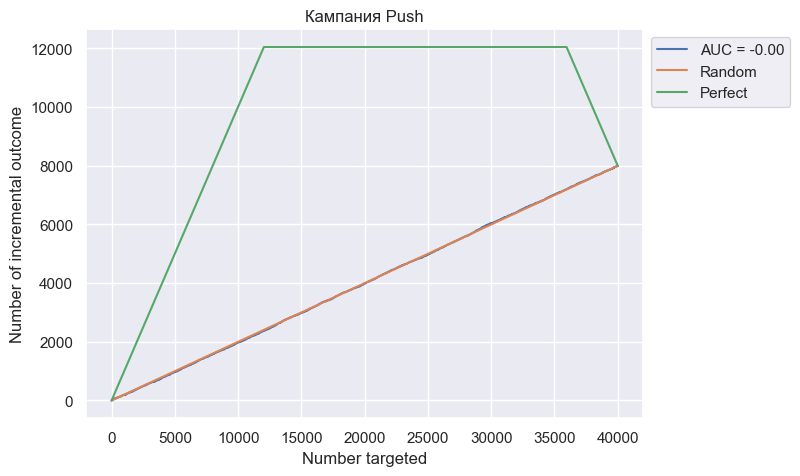

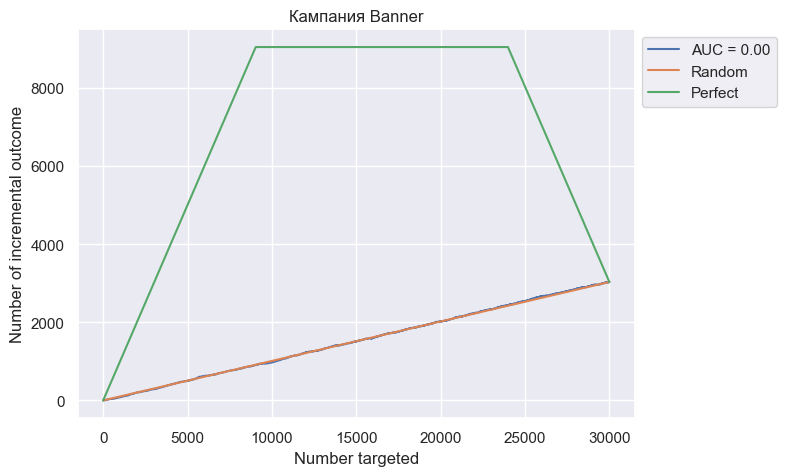

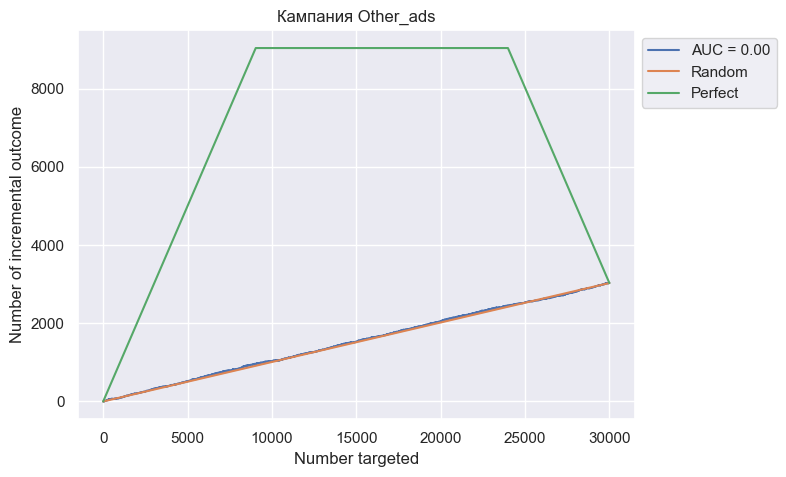

In [201]:
plot_qini_curve(y_true=y_test_push, uplift=uplift_push, treatment=X_test_push['t_flag'].astype(int))
plt.title('Кампания Push')
plt.show()

plot_qini_curve(y_true=y_test_banner, uplift=uplift_banner, treatment=X_test_banner['t_flag'].astype(int))
plt.title('Кампания Banner')
plt.show()

plot_qini_curve(y_true=y_test_other, uplift=uplift_other, treatment=X_test_other['t_flag'].astype(int))
plt.title('Кампания Other_ads')
plt.show()

<h2>4. Подготовка ответа в требуемом формате и подготовка выводов (6 баллов)</h2>

a) Сделайте скоринг нужных клиентов, подготовьте ответ в требуемом формате

б) Сделайте краткую аналитику того, какой канал взаимодействия наиболее предпочтителен

в) Сделайте выводы по проделанной работе

**Комментарий по заданиям и оцениванию:**

* Подготовлен только ответ - **1 балл**
* Подготовлен содержательный вывод по проделанной работе - **4 балла**
* Корректно принято решение об отправке/не отправке коммуникации клиентам в зависимости от значений Uplift - **1 балл**

In [83]:
def get_expected_uplift(X_train, y_train, X_test):
    X_train['t_flag'] = X_train['t_flag'].astype(int)
    X_test['t_flag'] = X_test['t_flag'].astype(int)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    base_model = CatBoostClassifier(logging_level='Silent', random_state=RANDOM_STATE, thread_count=-1)
    calib_base_model = CalibratedClassifierCV(base_model, method='isotonic', cv=skf)
    solo = SoloModel(calib_base_model)
    pipe = Pipeline(steps=[
        ('scaler', MinMaxScaler()),
        ('model_uplift', solo)
    ])
    pipe.fit(X_train.drop(columns=['t_flag']).values,
            y_train.values,
            model_uplift__treatment=X_train['t_flag'].values)
    uplift_pipe_pred = pipe.predict(X=X_test.drop(columns=['t_flag']).values)
    return uplift_pipe_pred

In [74]:
# скоринг клиентов
'''
Здесь чтобы провести скоринг клиентов на март объединим обучающую и тестовые выборки за ноябрь, на них обучим модель.
А предскажем аплифт на мартовских агрегатах (с учетом лага в 2 месяца).
'''

X_push, y_push = push_df.drop(columns=['target', 'stratify']), push_df['target']
X_banner, y_banner = banner_df.drop(columns=['target', 'stratify']), banner_df['target']
X_other, y_other = other_ads_df.drop(columns=['target', 'stratify']), other_ads_df['target']

In [ ]:
# берем данные из агрегатов (тут из report_dt я уже вычел два месяца)
# закодируем признаки, чтобы были 1-в-1 как в обучающих данных

X_forecast = features[features['report_dt'] == '2025-01-01']
X_forecast['t_flag'] = 1
X_forecast['city_Smolensk'] = np.where(X_forecast['city'] == 'Smolensk', 1, 0)
X_forecast['city_Ufa'] = np.where(X_forecast['city'] == 'Ufa', 1, 0)
X_forecast = X_forecast.drop(columns=['report_dt', 'city'])
X_forecast.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,user_id,age,t_flag,city_Smolensk,city_Ufa
2,0.296030,-0.937075,1.073280,1.874636,-0.981216,-1.100187,-0.331181,-1.575637,0.474965,4063636,28,1,0,1
3,2.329328,-1.345159,0.345066,0.755373,-0.082842,0.028439,0.919211,0.808793,-0.560004,1025488,27,1,0,0
5,1.484212,-1.740581,3.667611,-0.210718,-1.052699,1.191575,-2.013569,-3.359449,1.560199,36478,42,1,0,0
8,-2.330734,0.399864,-0.101855,2.800774,-1.632550,1.006098,0.438571,0.330793,0.163269,4032069,22,1,1,0
9,1.806567,-1.356962,2.721992,-1.827954,0.166162,0.841758,1.295022,-0.142821,-0.865392,104929,35,1,0,0


In [87]:
#  для каждого юзера посчитаем потенциальный аплифт от каждой кампании

forecast_uplift_push = get_expected_uplift(X_push, y_push, X_forecast.drop(columns=['user_id']))
forecast_uplift_banner = get_expected_uplift(X_banner, y_banner, X_forecast.drop(columns=['user_id']))
forecast_uplift_other = get_expected_uplift(X_other, y_other, X_forecast.drop(columns=['user_id']))

In [92]:
push_forecast = pd.DataFrame({
    'user_id': X_forecast['user_id'],
    'report_dt': ['2025-01-31']*X_forecast.shape[0],
    'channel': ['push']*X_forecast.shape[0],
    'uplift': forecast_uplift_push
})
push_forecast.head()

,user_id,report_dt,channel,uplift
2,4063636,2025-01-31,push,0.400132
3,1025488,2025-01-31,push,0.399889
5,36478,2025-01-31,push,0.310615
8,4032069,2025-01-31,push,0.389397
9,104929,2025-01-31,push,0.382547


In [93]:
banner_forecast = pd.DataFrame({
    'user_id': X_forecast['user_id'],
    'report_dt': ['2025-01-31']*X_forecast.shape[0],
    'channel': ['banner']*X_forecast.shape[0],
    'uplift': forecast_uplift_banner
})
banner_forecast.head()

,user_id,report_dt,channel,uplift
2,4063636,2025-01-31,banner,0.176686
3,1025488,2025-01-31,banner,0.197715
5,36478,2025-01-31,banner,0.076522
8,4032069,2025-01-31,banner,0.190636
9,104929,2025-01-31,banner,0.115458


In [94]:
other_forecast = pd.DataFrame({
    'user_id': X_forecast['user_id'],
    'report_dt': ['2025-01-31']*X_forecast.shape[0],
    'channel': ['other_ads']*X_forecast.shape[0],
    'uplift': forecast_uplift_other
})
other_forecast.head()

,user_id,report_dt,channel,uplift
2,4063636,2025-01-31,other_ads,0.152310
3,1025488,2025-01-31,other_ads,0.167671
5,36478,2025-01-31,other_ads,0.201381
8,4032069,2025-01-31,other_ads,0.155993
9,104929,2025-01-31,other_ads,0.187267


In [100]:
# объединим в одну итоговую таблицу
forecast = pd.concat([push_forecast, banner_forecast, other_forecast], axis=0).sort_values(by=['user_id']).reset_index(drop=True)
forecast

,user_id,report_dt,channel,uplift
0,1,2025-01-31,banner,0.099930
1,1,2025-01-31,push,0.313910
2,1,2025-01-31,other_ads,0.128115
3,2,2025-01-31,other_ads,0.198218
4,2,2025-01-31,banner,0.160357
...,...,...,...,...
1379995,4119998,2025-01-31,push,0.369385
1379996,4119998,2025-01-31,banner,0.153761
1379997,4119999,2025-01-31,other_ads,0.185267
1379998,4119999,2025-01-31,banner,0.025423


In [107]:
# но для бизнеса нам нужно ответить на вопрос "так кому что отправляем?", поэтому построим сводную таблицу
forecast_pivot = forecast.pivot_table(values=['uplift'], index='user_id', columns=['channel'])
forecast_pivot.head()

uplift                    
channel    banner other_ads      push
user_id                              
1        0.099930  0.128115  0.313910
2        0.160357  0.198218  0.388939
3        0.209122  0.168806  0.352290
4        0.193297  0.190237  0.401229
5        0.225021  0.142879  0.355234

In [117]:
def get_best_channel_for_user(row):
    push_uplift = row[('uplift', 'push')]
    banner_uplift = row[('uplift', 'banner')]
    other_ads_uplift = row[('uplift', 'other_ads')]
    if push_uplift == max([push_uplift, banner_uplift, other_ads_uplift]):
        return 'push'
    elif banner_uplift == max([push_uplift, banner_uplift, other_ads_uplift]):
        return 'banner'
    else:
        return 'other_ads'

forecast_pivot['best_channel_name'] = forecast_pivot.apply(get_best_channel_for_user, axis=1)
forecast_pivot.head()

uplift                     best_channel_name
channel    banner other_ads      push                  
user_id                                                
1        0.099930  0.128115  0.313910              push
2        0.160357  0.198218  0.388939              push
3        0.209122  0.168806  0.352290              push
4        0.193297  0.190237  0.401229              push
5        0.225021  0.142879  0.355234              push

In [121]:
forecast_pivot['best_channel_name'].value_counts()

best_channel_name
push         459673
other_ads       245
banner           82
Name: count, dtype: int64

In [128]:
forecast_pivot.groupby('best_channel_name')['uplift'].mean()

uplift                    
channel              banner other_ads      push
best_channel_name                              
banner             0.206131  0.143186  0.180016
other_ads          0.142087  0.232776  0.208040
push               0.160398  0.165960  0.379845

### Аналитика по каналам взаимодействия:
1. Кампания "sms" работает некорректно: точнее сплитовалка определяет в эту контрольную группу клиентов из целевой группы кампании "push".
2. Кампании "banner" и "other_ads" в среднем дают прирост в 20 п.п. конверсии в покупку по сравнению с контрольной группой.
3. Кампания "push" в среднем дает прирост в 40 п.п. конверсии в покупку по сравнению с контрольной группой, что является лучшей кампанией среди рассмотренных.
4. Сплитовалка работает корректно на данных трех кампаниях: группы гомогенны, стат значимых различий между ними нет.

### Выводы по итогам работы:

1. Наилучшая аплифт-модель - калиброванный CatBoost с использованием пайплайна, именно ее использовали для скоринга клиентов. В среднем qini score равен 0.002.
2. В работе получал крайне низкие значения qini score (перепроверял все раз 5, но может где что-то упустил), хотя видна визульно разница между конверсиями теста и контроля в каждой из трех кампаний.
3. Так же плохое качество показала модель UpliftRandomForest, даже хуже чем SoloModel c LogReg, что тоже очень странно...
4. После рекомендаций на январских агрегата получил интересный результат: 99% клиентов стоит отправить пуш, именно он привлечет к наибольшему аплифту. 245 клиентам стоит использовать канал коммуникаций "other_ads", а 82 клиентам - "banner".
5. В среднем аплифт push = 0.38, banner = 0.21, other_ads = 0.23.